<div style="background-color:#f7f9fb; border-left:6px solid #2B6CB0; padding:18px 16px; border-radius:8px; margin:18px 0;">

<h1 style="margin:0 0 8px 0; font-size:26px; line-height:1.25; color:#0f172a;">
SA-ROC Framework — Tutorial & Usage Guide
</h1>

<p style="margin:0; font-size:16px; color:#1f2937;">
This notebook demonstrates how to apply <code>SA_ROC_Analyzer</code> to evaluate the operational safety of a clinical AI model. The tutorial proceeds from basic setup to policy-aware analysis, emphasizing reproducible, decision-oriented reporting.
</p>

<hr style="border:none; border-top:1px solid #e5e7eb; margin:16px 0;">

<h3 style="margin:0 0 8px 0; font-size:18px; color:#0f172a;">What you will do</h3>
<ol style="margin:0 0 0 18px; padding:0; color:#111827; font-size:16px;">
  <li>Load example data (model scores and binary labels).</li>
  <li>Initialize the analyzer and compute a performance profile.</li>
  <li>Specify a clinical safety policy (rule-out / rule-in criteria).</li>
  <li>Visualize SA-ROC and related diagnostics for safe operations.</li>
</ol>

<p style="margin:12px 0 0 0; font-size:14px; color:#4b5563;">
In later sections, we also demonstrate advanced policy routines: dual-safety thresholding, capped-gray strategies (rule-in and rule-out), and utility-maximizing policy selection.
</p>

<hr style="border:none; border-top:1px solid #e5e7eb; margin:16px 0;">

<h3 style="margin:0 0 8px 0; font-size:18px; color:#0f172a;">Data & assumptions</h3>
<ul style="margin:0 0 0 18px; padding:0; color:#111827; font-size:16px;">
  <li><strong>Scores:</strong> continuous values in [0, 1].</li>
  <li><strong>Labels:</strong> binary {0, 1}, with both classes present.</li>
  <li><strong>Objective:</strong> translate policy targets (e.g., NPV ≥ α<sup>−</sup>, PPV ≥ α<sup>+</sup>) into operational thresholds and safe/gray zones.</li>
</ul>

<p style="margin:12px 0 0 0; font-size:14px; color:#4b5563;">
All figures render under a non-interactive backend and are saved to disk for portability (e.g., CI environments).
</p>

</div>


In [1]:
# Data bootstrap for SA-ROC tutorial
# - Tries to load 'data/example_data.csv' (ID, Score, Label)
# - If not present, falls back to existing variables (scores, labels)
# - If neither available, creates a reproducible sample and saves it to CSV
# - Initializes SA_ROC_Analyzer and prints base AUC

import os, sys
import pandas as pd
import numpy as np

# -----------------------------------------------------------------------------
# 0) Import SA_ROC_Analyzer with robust path handling
# -----------------------------------------------------------------------------
def _try_import_analyzer():
    try:
        from saroc.analyzer import SA_ROC_Analyzer  # noqa: F401
        return True
    except Exception as e:
        print("Import failed:", repr(e))
        return False

if not _try_import_analyzer():
    # Add likely repo roots to sys.path and retry
    cwd = os.path.abspath(os.getcwd())
    for p in [cwd, os.path.dirname(cwd), os.path.dirname(os.path.dirname(cwd))]:
        if p not in sys.path:
            sys.path.insert(0, p)
    if not _try_import_analyzer():
        raise ImportError(
            "Could not import SA_ROC_Analyzer. Ensure 'saroc/analyzer.py' exists "
            "and that the repository root is on PYTHONPATH."
        )

from saroc.analyzer import SA_ROC_Analyzer  # type: ignore

# -----------------------------------------------------------------------------
# 1) CSV configuration
# -----------------------------------------------------------------------------
# You can change this to your dataset path, e.g.:
# DATA_CSV_PATH = "your_path/your_file.csv"
DATA_CSV_PATH = "data/example_data.csv"   # <- default expected location
CSV_REQUIRED_COLS = {"Score", "Label"}
CSV_OPTIONAL_COLS = {"ID"}

# -----------------------------------------------------------------------------
# 2) Utilities: CSV loader with validation
# -----------------------------------------------------------------------------
def load_scores_labels_from_csv(path: str):
    """
    Load (scores, labels) from CSV with columns: ID(optional), Score, Label.
    - Score: float in [0, 1]
    - Label: binary {0, 1}; if two unique values not in {0,1}, map them to 0/1 in sorted order.
    Returns: (scores: np.ndarray, labels: np.ndarray, ids: np.ndarray or None)
    Raises: ValueError with informative messages on validation failures.
    """
    if not os.path.exists(path):
        return None

    try:
        df = pd.read_csv(path)
    except Exception as e:
        raise ValueError(f"Failed to read CSV at '{path}': {e}")

    cols = set(df.columns)
    if not CSV_REQUIRED_COLS.issubset(cols):
        missing = ", ".join(sorted(CSV_REQUIRED_COLS - cols))
        raise ValueError(f"CSV missing required columns: {missing}. Found columns: {list(df.columns)}")

    # IDs are optional; generate if not present
    ids = df["ID"].astype(str).values if "ID" in df.columns else None

    # Validate and coerce Score
    try:
        scores = df["Score"].astype(float).values
    except Exception:
        raise ValueError("Column 'Score' must be numeric (float).")
    if np.any(np.isnan(scores)):
        raise ValueError("Column 'Score' contains NaN values.")
    if np.any((scores < 0.0) | (scores > 1.0)):
        raise ValueError("Column 'Score' must lie within [0, 1].")

    # Validate and coerce Label
    # Accept {0,1} or any 2 unique values (map to {0,1} by sorted order)
    uniq = pd.unique(df["Label"])
    if len(uniq) == 0:
        raise ValueError("Column 'Label' is empty.")
    if len(uniq) == 1:
        raise ValueError("Column 'Label' contains only one class. Both classes {0,1} are required.")
    if set(uniq).issubset({0, 1}):
        labels = df["Label"].astype(int).values
    else:
        # Map sorted unique labels to {0,1}
        uniq_sorted = sorted(uniq)
        mapping = {uniq_sorted[0]: 0, uniq_sorted[1]: 1}
        try:
            labels = df["Label"].map(mapping).astype(int).values
        except Exception:
            raise ValueError(f"Failed to map labels to {{0,1}}. Unique labels: {list(uniq)}")

    return scores, labels, ids

# -----------------------------------------------------------------------------
# 3) Prepare data from CSV / existing variables / synthetic sample
# -----------------------------------------------------------------------------
def prepare_data(csv_path: str):
    # (A) Try CSV first
    try:
        loaded = load_scores_labels_from_csv(csv_path)
        if loaded is not None:
            scores_csv, labels_csv, ids_csv = loaded
            print(f"✓ Loaded {len(labels_csv)} rows from '{csv_path}'")
            return scores_csv, labels_csv, ids_csv
    except Exception as e:
        print(f"⚠️ CSV load warning: {e}")
        print("   Falling back to in-memory variables or synthetic sample.")

    # (B) Fall back to in-memory variables if present
    g = globals()
    if "scores" in g and "labels" in g:
        print("✓ Using existing `scores` and `labels` from earlier cells.")
        return np.asarray(g["scores"], dtype=float), np.asarray(g["labels"], dtype=int), None

    # (C) Create a synthetic sample using Beta distributions
    rng = np.random.default_rng(17)
    n = 1000
    prevalence = 0.5
    n_pos = int(n * prevalence)
    n_neg = n - n_pos

    # Class 1 (positive)
    scores_pos = rng.beta(4, 2, size=n_pos)

    # Class 0 (negative)
    scores_neg = rng.beta(2, 4, size=n_neg)

    scores = np.concatenate([scores_pos, scores_neg])
    labels = np.concatenate([np.ones(n_pos, dtype=int), np.zeros(n_neg, dtype=int)])
    ids = np.array([f"case_{i:04d}" for i in range(1, n + 1)])

    # Shuffle the dataset
    indices = rng.permutation(n)
    scores = scores[indices]
    labels = labels[indices]
    ids = ids[indices]

    # Save to CSV
    os.makedirs(os.path.dirname(csv_path), exist_ok=True)
    df_out = pd.DataFrame({"ID": ids, "Score": scores, "Label": labels})
    df_out.to_csv(csv_path, index=False)
    print(f"✓ Synthetic data created and saved to '{csv_path}'")

    return scores, labels, ids


scores, labels, ids = prepare_data(DATA_CSV_PATH)

# -----------------------------------------------------------------------------
# 4) Initialize analyzer and report base AUC
# -----------------------------------------------------------------------------
an = SA_ROC_Analyzer(scores, labels, verbose=True)
print(f"AUC (base): {an.roc_auc:.3f} | n={len(labels)} | prevalence={labels.mean():.3f}")

# Optional: where to save figures later in the tutorial
FIG_DIR = "figs"
os.makedirs(FIG_DIR, exist_ok=True)

✓ Loaded 1000 rows from 'data/example_data.csv'
-> Calculating model performance profile...
-> Performance profile created. Base AUC: 0.899
AUC (base): 0.899 | n=1000 | prevalence=0.500


<div style="background-color:#f7f9fb; border-left:6px solid #2B6CB0; padding:18px 16px; border-radius:8px; margin:18px 0;">

<h2 style="margin:0 0 8px 0; font-size:22px; line-height:1.3; color:#0f172a;">
Define Policy & Generate Core Diagnostics
</h2>

<p style="margin:0; font-size:16px; color:#1f2937;">
In this section, we (i) specify a clinical safety policy and an operational threshold, and (ii) render three key visual diagnostics:
</p>

<ol style="margin:10px 0 0 18px; padding:0; color:#111827; font-size:16px;">
  <li><strong>SA-ROC with 95% CI</strong> — the ROC polyline colored by policy satisfaction with optional bootstrap confidence bands (reported in the title).</li>
  <li><strong>Combined Jitter & Score Distributions</strong> — individual scores by class (top) and class-conditional densities (bottom), with rule-out/rule-in zones highlighted.</li>
  <li><strong>Safety Profile Curve</strong> — Γ<sub>Area</sub> (operational uncertainty) and the % of the cohort in the gray zone as a function of the safety level α.</li>
</ol>

<p style="margin:12px 0 0 0; font-size:14px; color:#4b5563;">
Policy parameters use the convention: <strong>α<sub>−</sub></strong> for NPV (rule-out) and <strong>α<sub>+</sub></strong> for PPV (rule-in). We choose the operational threshold <code>τ<sub>op</sub></code> as the median of predicted scores for demonstration; in practice, it should reflect the intended operating point in deployment.
</p>

</div>



Using operational threshold (median score): 0.493
Policy analysis → valid=True, τ_minus=0.100, τ_plus=0.686, Γ_Area=0.444

--- Generating SA-ROC Plot ---
-> Plotting SA-ROC curve for policy: {'alpha_minus': 0.99, 'alpha_plus': 0.95}

-> Starting bootstrap for CI calculation (100 iterations)...


  0%|          | 0/100 [00:00<?, ?it/s]

-> Bootstrap CI calculation complete.
-> Plot saved to figs\sa_roc_with_ci.png


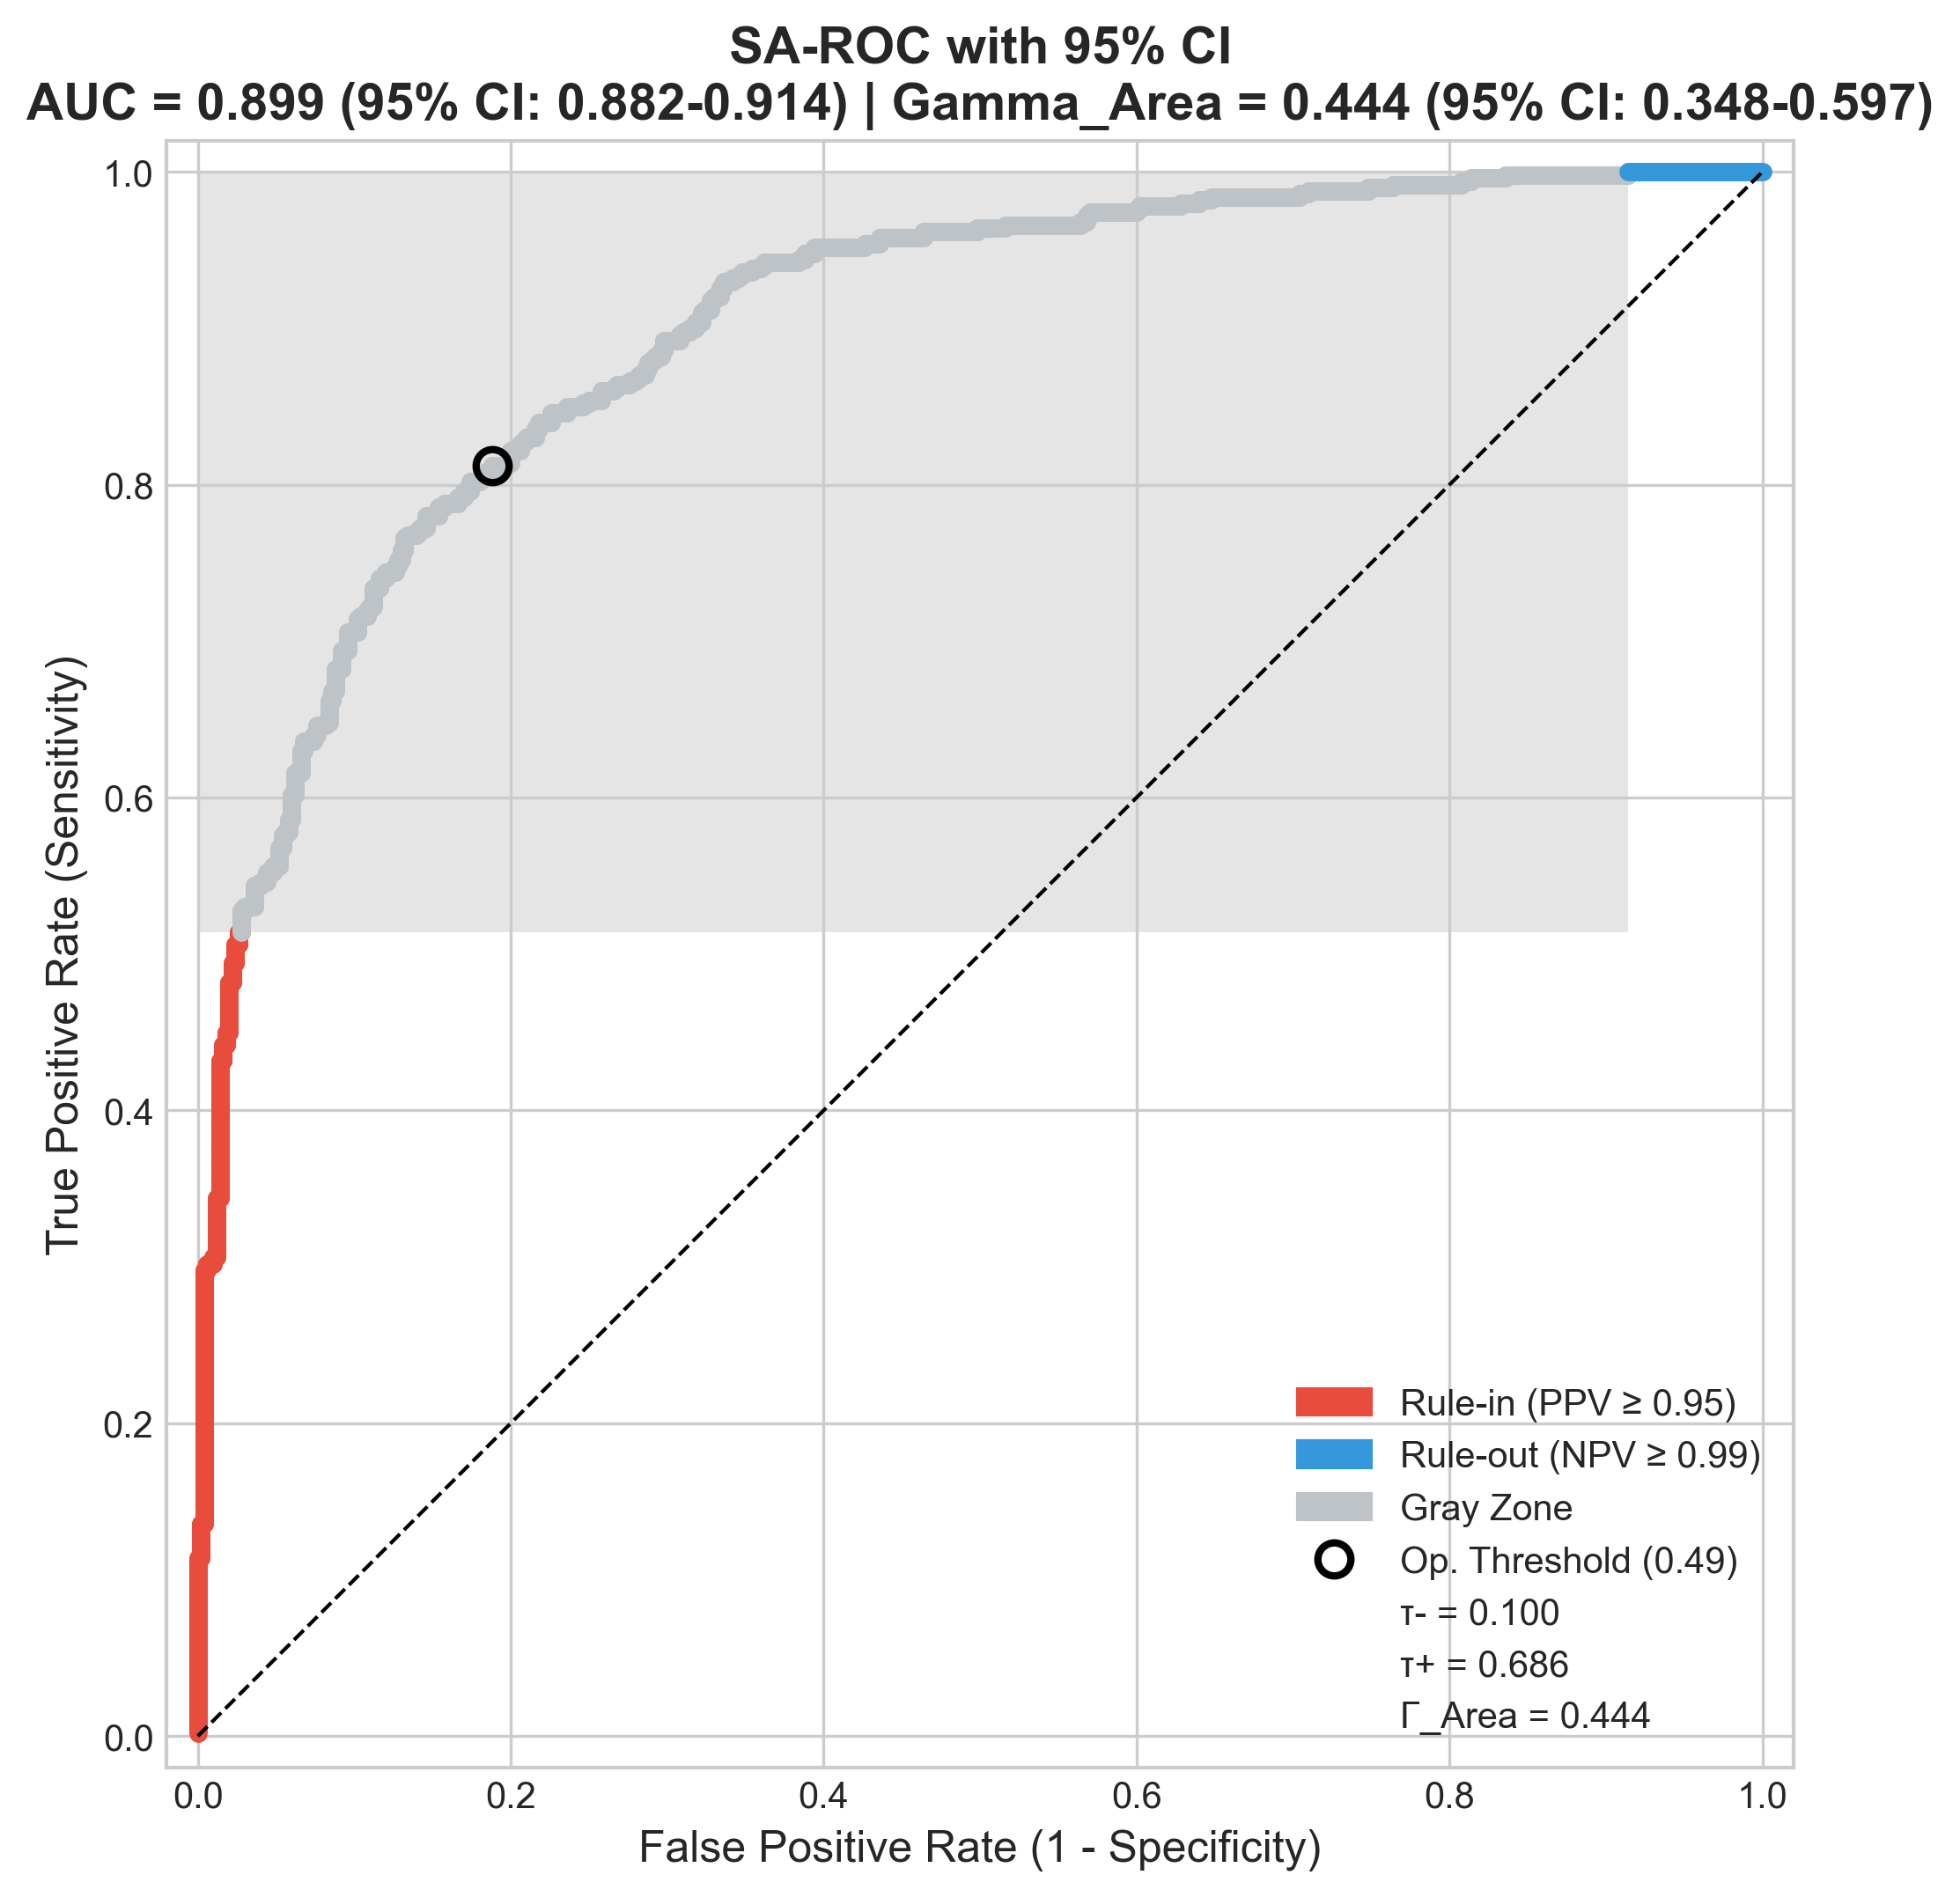


--- Generating Combined Jitter & Distribution Plot ---
-> Plotting combined jitter and distribution plot...
-> Plot saved to figs\jitter_distributions.png


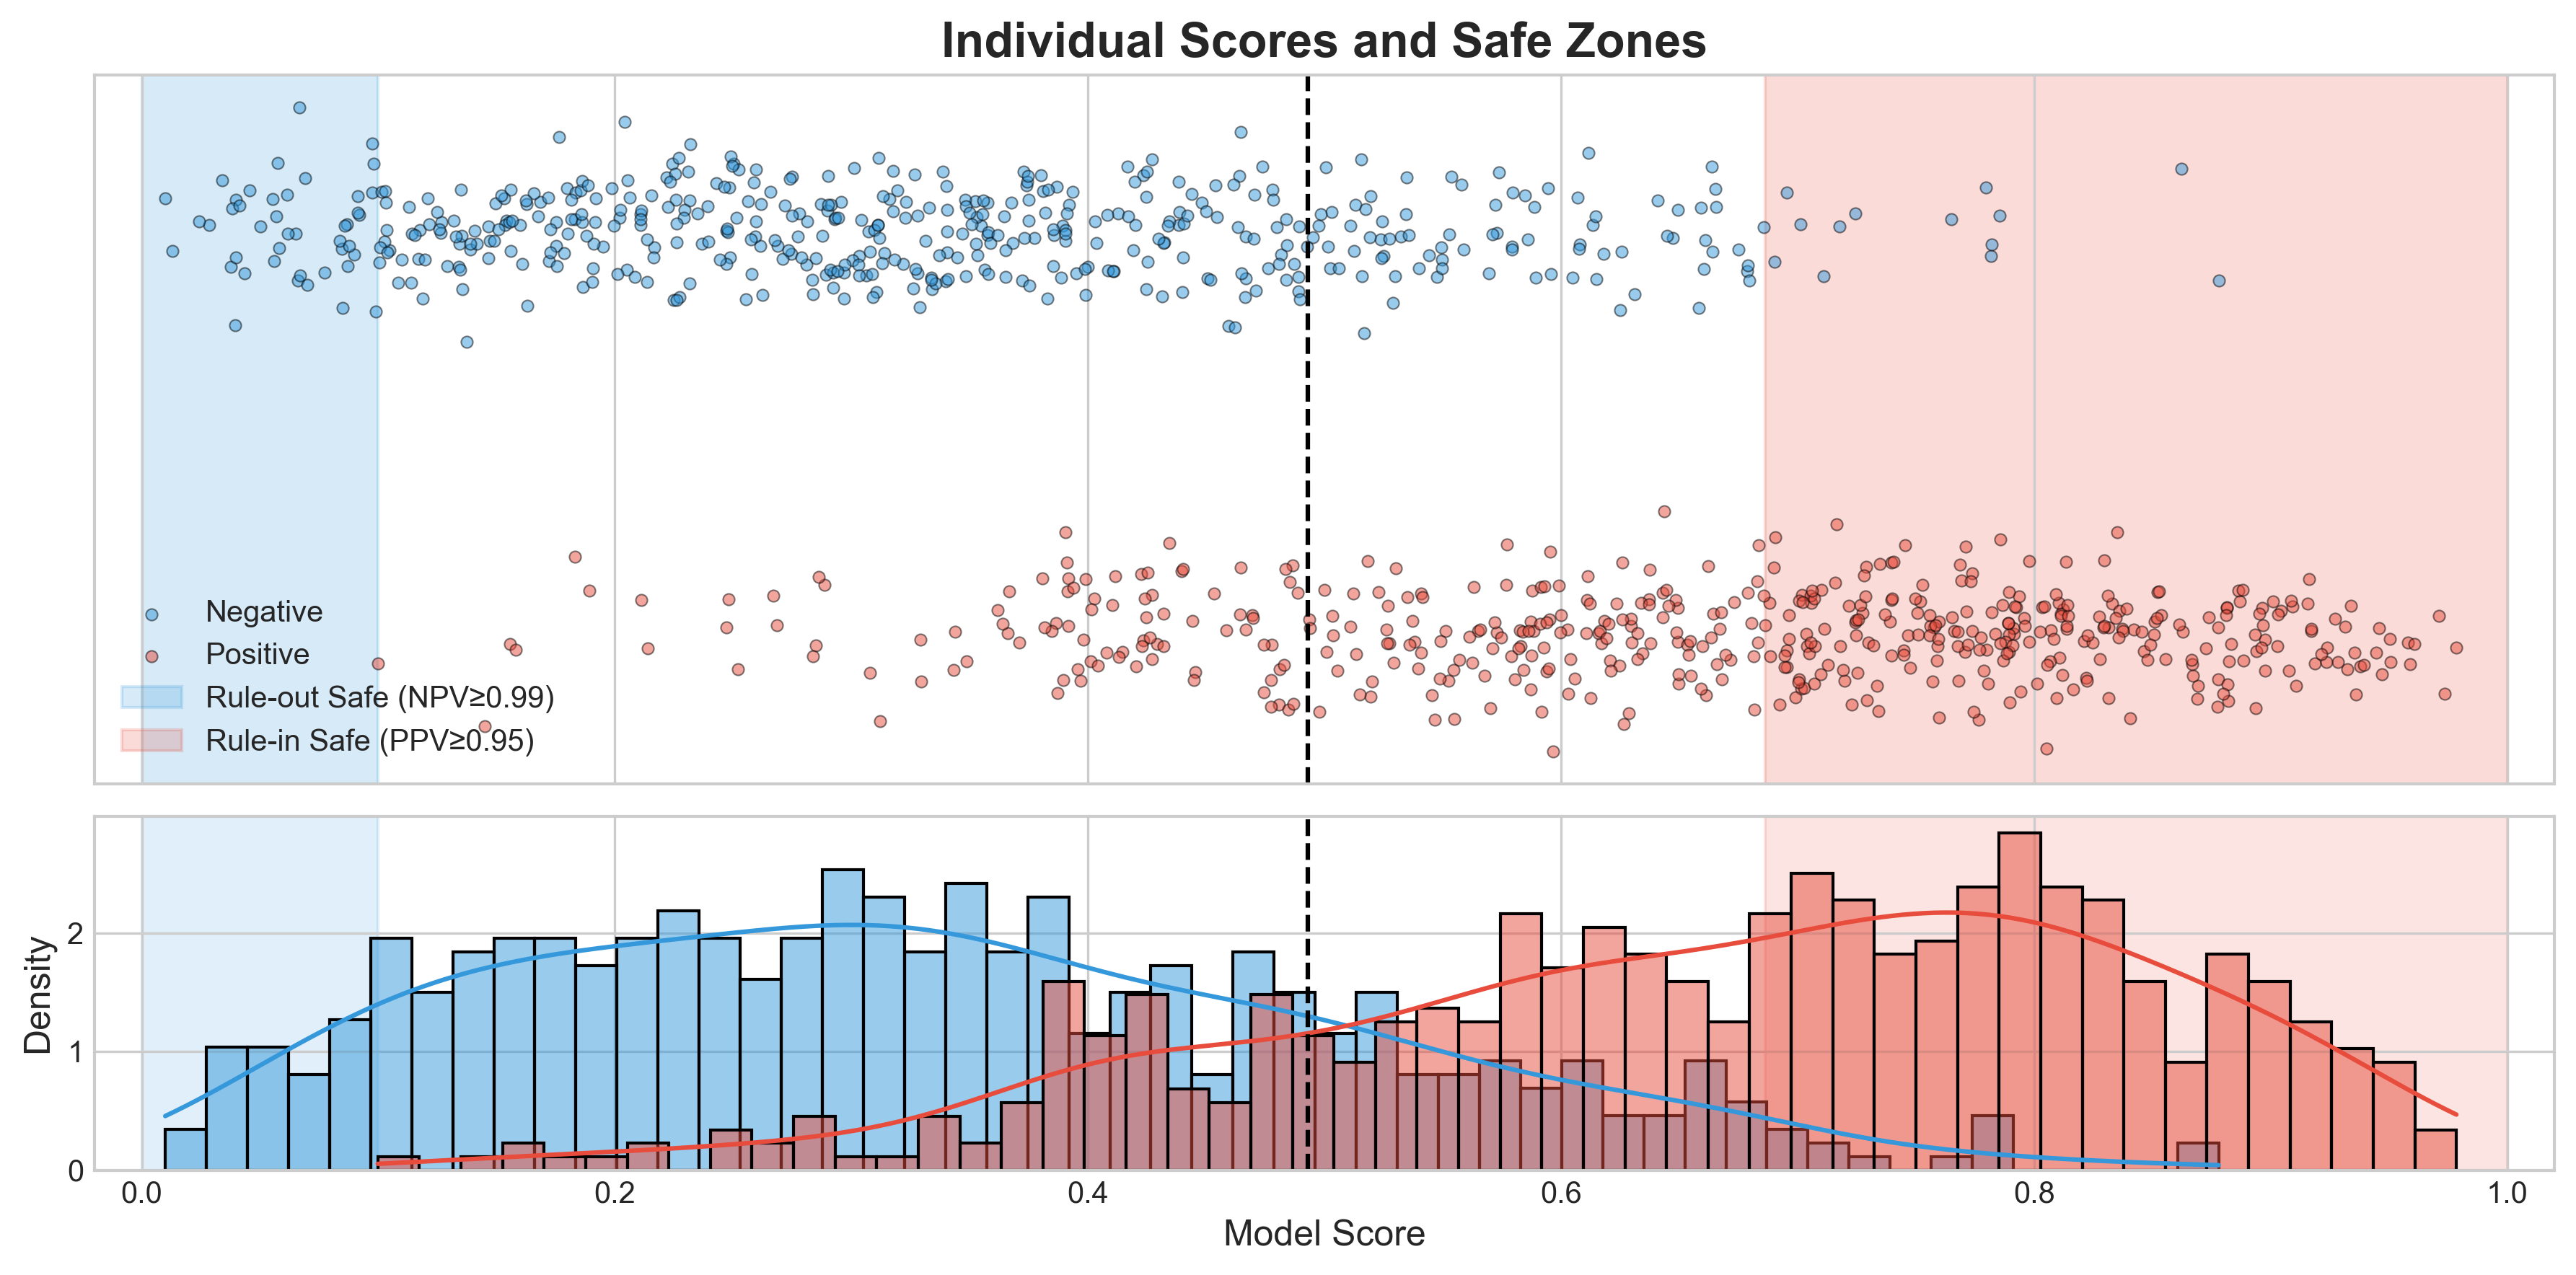


--- Generating Safety Profile Plot ---
-> Plotting safety profile curve...
-> Plot saved to figs\safety_profile.png


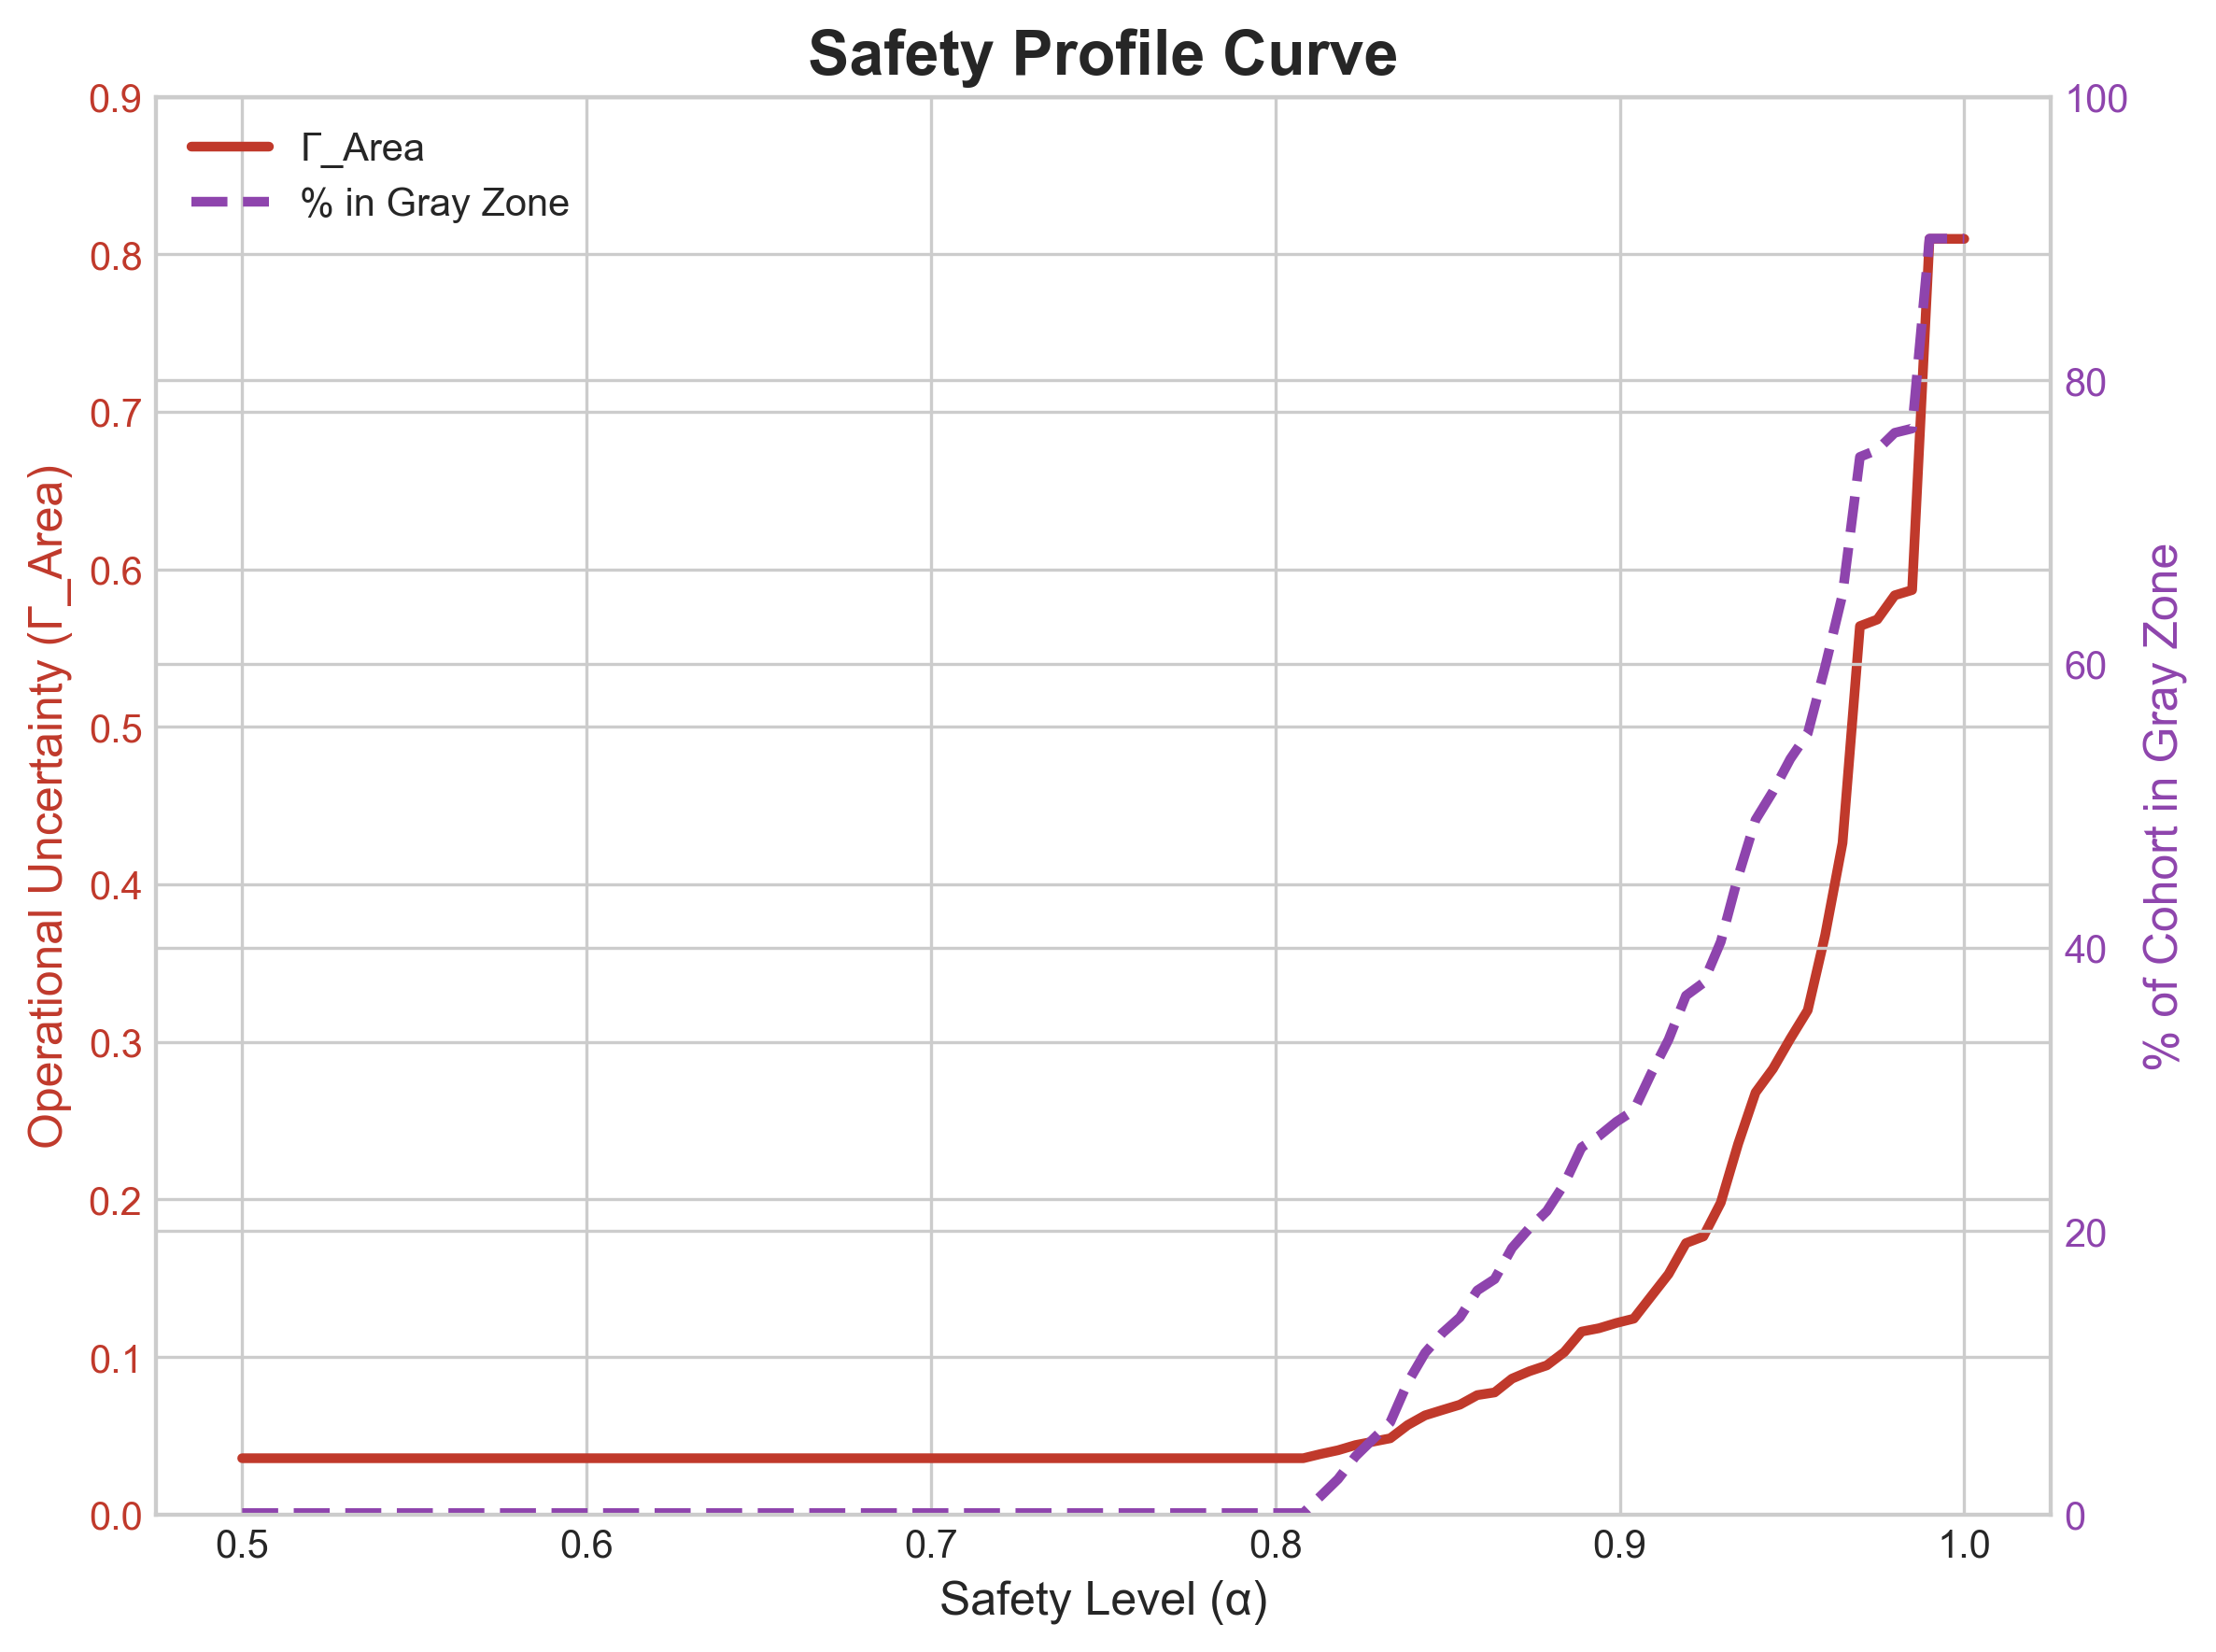


✓ Finished rendering all figures.


In [2]:
# Define a clinical policy, choose an operational threshold, and render the three core figures.
# Figures are saved under FIG_DIR and displayed inline.

import os
import numpy as np
from IPython.display import Image, display

# Ensure analyzer and data exist (from previous cells)
try:
    an  # SA_ROC_Analyzer instance
    scores, labels  # numpy arrays
except NameError as e:
    raise RuntimeError("Prerequisite objects not found. Run the data/bootstrap cell first.") from e

# -----------------------------
# 1) Policy & operational threshold
# -----------------------------
policy = {
    "alpha_minus": 0.99,  # NPV target (rule-out safety)
    "alpha_plus":  0.95,  # PPV target (rule-in safety)
}

op_threshold = float(np.median(scores))  # demo operating point
print(f"\nUsing operational threshold (median score): {op_threshold:.3f}")

# Optional: quick policy sanity check
analysis = an.analyze_policy(policy, op_threshold)
print(
    "Policy analysis → "
    f"valid={analysis['is_valid_policy']}, "
    f"τ_minus={analysis['t_rule_out']:.3f}, τ_plus={analysis['t_rule_in']:.3f}, "
    f"Γ_Area={analysis['gamma_area']:.3f}"
)

# Make sure output dir exists
FIG_DIR = "figs"
os.makedirs(FIG_DIR, exist_ok=True)

# -----------------------------
# 2) SA-ROC with 95% CI
# -----------------------------
print("\n--- Generating SA-ROC Plot ---")
# Set n_bootstraps to a modest number for interactive speed; increase (e.g., 1000–2000) for publication-grade CI.
sa_roc_path = os.path.join(FIG_DIR, "sa_roc_with_ci.png")
_ = an.plot_sa_roc(
    policy,
    op_threshold=op_threshold,
    show_ci=True,
    n_bootstraps=100,     # ← increase for tighter CIs
    title="SA-ROC with 95% CI",
    save_path=sa_roc_path,
)
display(Image(sa_roc_path))

# -----------------------------
# 3) Combined Jitter & Score Distributions
# -----------------------------
print("\n--- Generating Combined Jitter & Distribution Plot ---")
jitter_dist_path = os.path.join(FIG_DIR, "jitter_distributions.png")
_ = an.plot_jitter_and_distributions(
    policy,
    op_threshold=op_threshold,
    save_path=jitter_dist_path,
)
display(Image(jitter_dist_path))

# -----------------------------
# 4) Safety Profile Curve
# -----------------------------
print("\n--- Generating Safety Profile Plot ---")
safety_profile_path = os.path.join(FIG_DIR, "safety_profile.png")
_ = an.plot_safety_profile(
    op_threshold=op_threshold,
    save_path=safety_profile_path,
)
display(Image(safety_profile_path))

print("\n✓ Finished rendering all figures.")

<div style="background-color:#f7f9fb; border-left:6px solid #2B6CB0; padding:18px 16px; border-radius:8px; margin:18px 0;">

<h2 style="margin:0 0 8px 0; font-size:22px; line-height:1.3; color:#0f172a;">
Policy Recommendation Routines
</h2>

<p style="margin:0; font-size:16px; color:#1f2937;">
This section demonstrates four policy-selection utilities that convert clinical targets into operational thresholds. Each routine outputs a pair of thresholds, <code>τ<sup>−</sup></code> (rule-out) and <code>τ<sup>+</sup></code> (rule-in), and provides a policy overview figure for quick interpretation.
</p>

<hr style="border:none; border-top:1px solid #e5e7eb; margin:16px 0;">

<ol style="margin:0 0 0 18px; padding:0; color:#111827; font-size:16px;">
  <li><strong>Dual-Satefy</strong> — Find <code>τ<sup>−</sup></code>, <code>τ<sup>+</sup></code> such that <em>NPV ≥ α<sup>−</sup></em> and <em>PPV ≥ α<sup>+</sup></em>, with <code>τ<sup>−</sup> &lt; τ<sup>+</sup></code>.</li>
  <li><strong>Capped Gray (Rule-in)</strong> — Fix the smallest <code>τ<sup>+</sup></code> with <em>PPV ≥ α<sup>+</sup></em>; then choose <code>τ<sup>−</sup></code> to maximize the gray zone subject to a workload cap (<em>% cohort in gray ≤ p</em>).</li>
  <li><strong>Capped Gray (Rule-out)</strong> — Fix the largest <code>τ<sup>−</sup></code> with <em>NPV ≥ α<sup>−</sup></em>; then choose <code>τ<sup>+</sup></code> to maximize the gray zone under the same cap.</li>
  <li><strong>Utility-Maximizing</strong> — Search <code>(τ<sup>−</sup>, τ<sup>+</sup>)</code> for the highest total expected utility:
      <span style="white-space:nowrap;">Utility = TN·U<sub>TN</sub> + FP·U<sub>FP</sub> + TP·U<sub>TP</sub> + FN·U<sub>FN</sub> + N<sub>gray</sub>·cost<sub>gray</sub></span>.
      A heatmap and a breakdown plot are provided.</li>
</ol>

<p style="margin:12px 0 0 0; font-size:14px; color:#4b5563;">
Tip — Start with conservative <em>α</em> targets to test feasibility. If no feasible solution exists, relax the targets incrementally or adjust the gray-zone cap.
</p>

</div>



[1] Dual-Safety Policy
   status: Success
   → τ_minus=0.100, τ_plus=0.535
-> Plot saved to figs\policy_dual_safety_overview.png


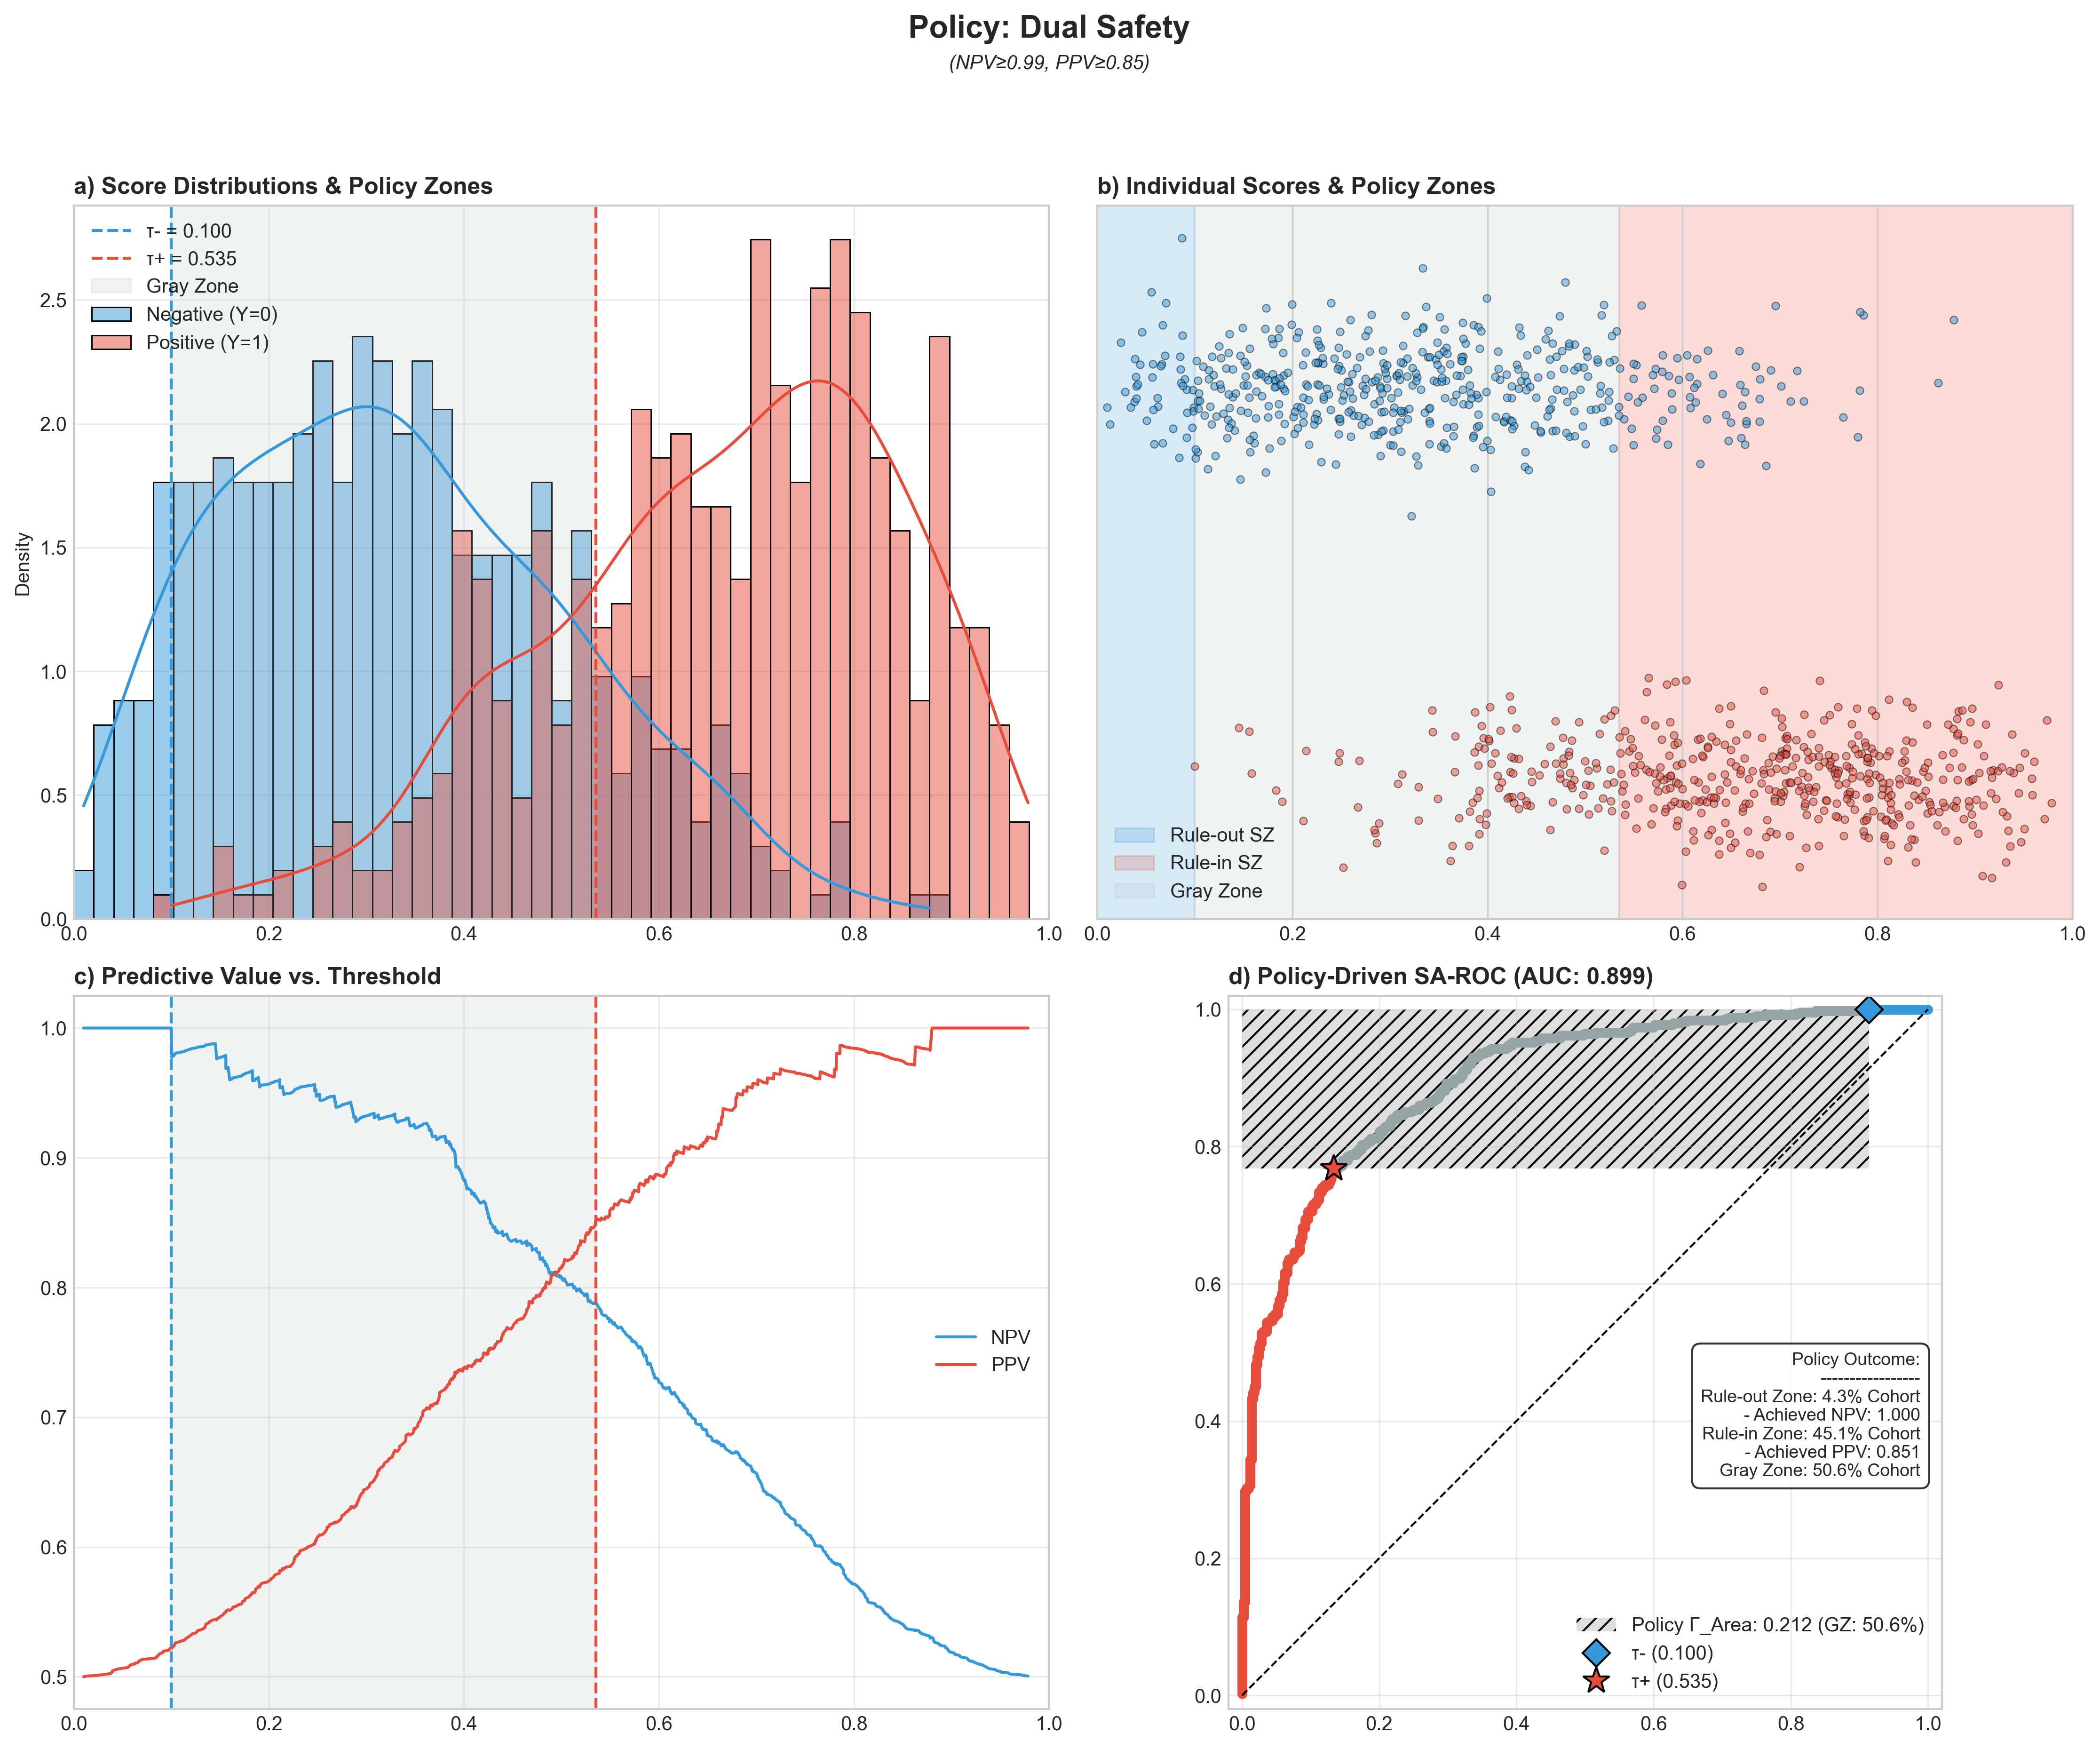


[2] Capped Gray (Rule-in)
   status: Success
   → τ_minus=0.296, τ_plus=0.615
-> Plot saved to figs\policy_capped_gray_rulein_overview.png


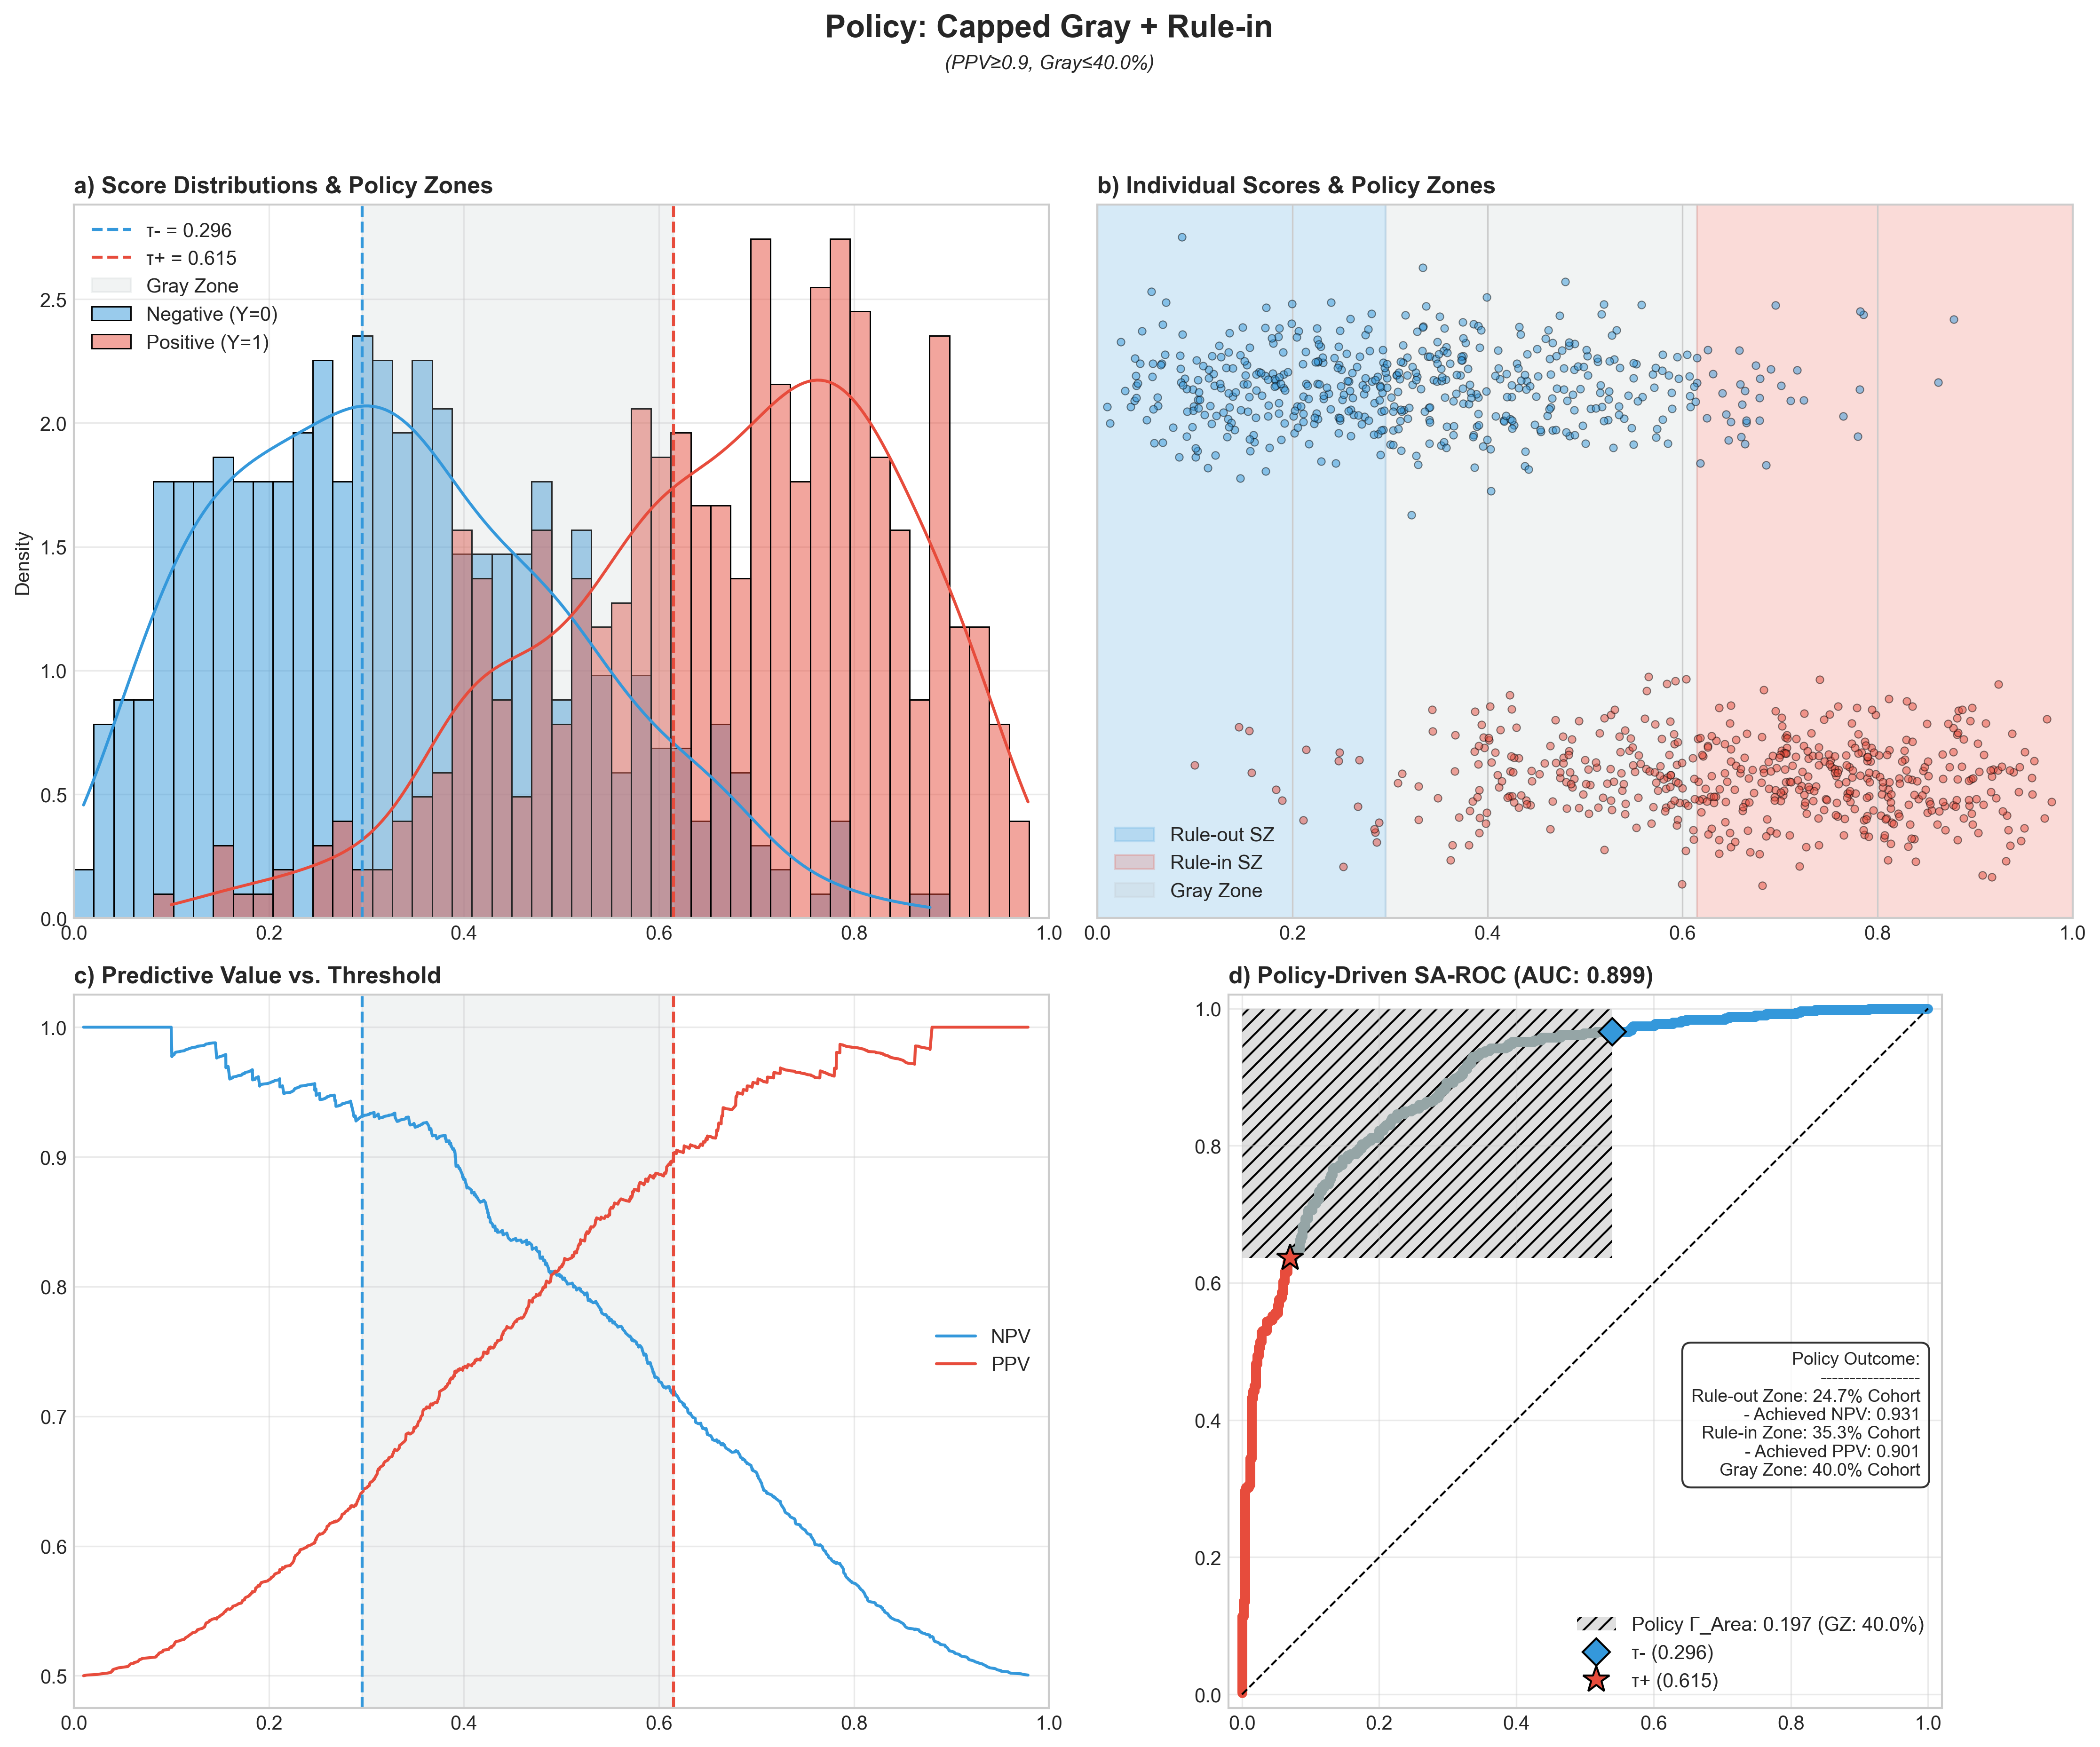


[3] Capped Gray (Rule-out)
   status: Success
   → τ_minus=0.100, τ_plus=0.293
-> Plot saved to figs\policy_capped_gray_ruleout_overview.png


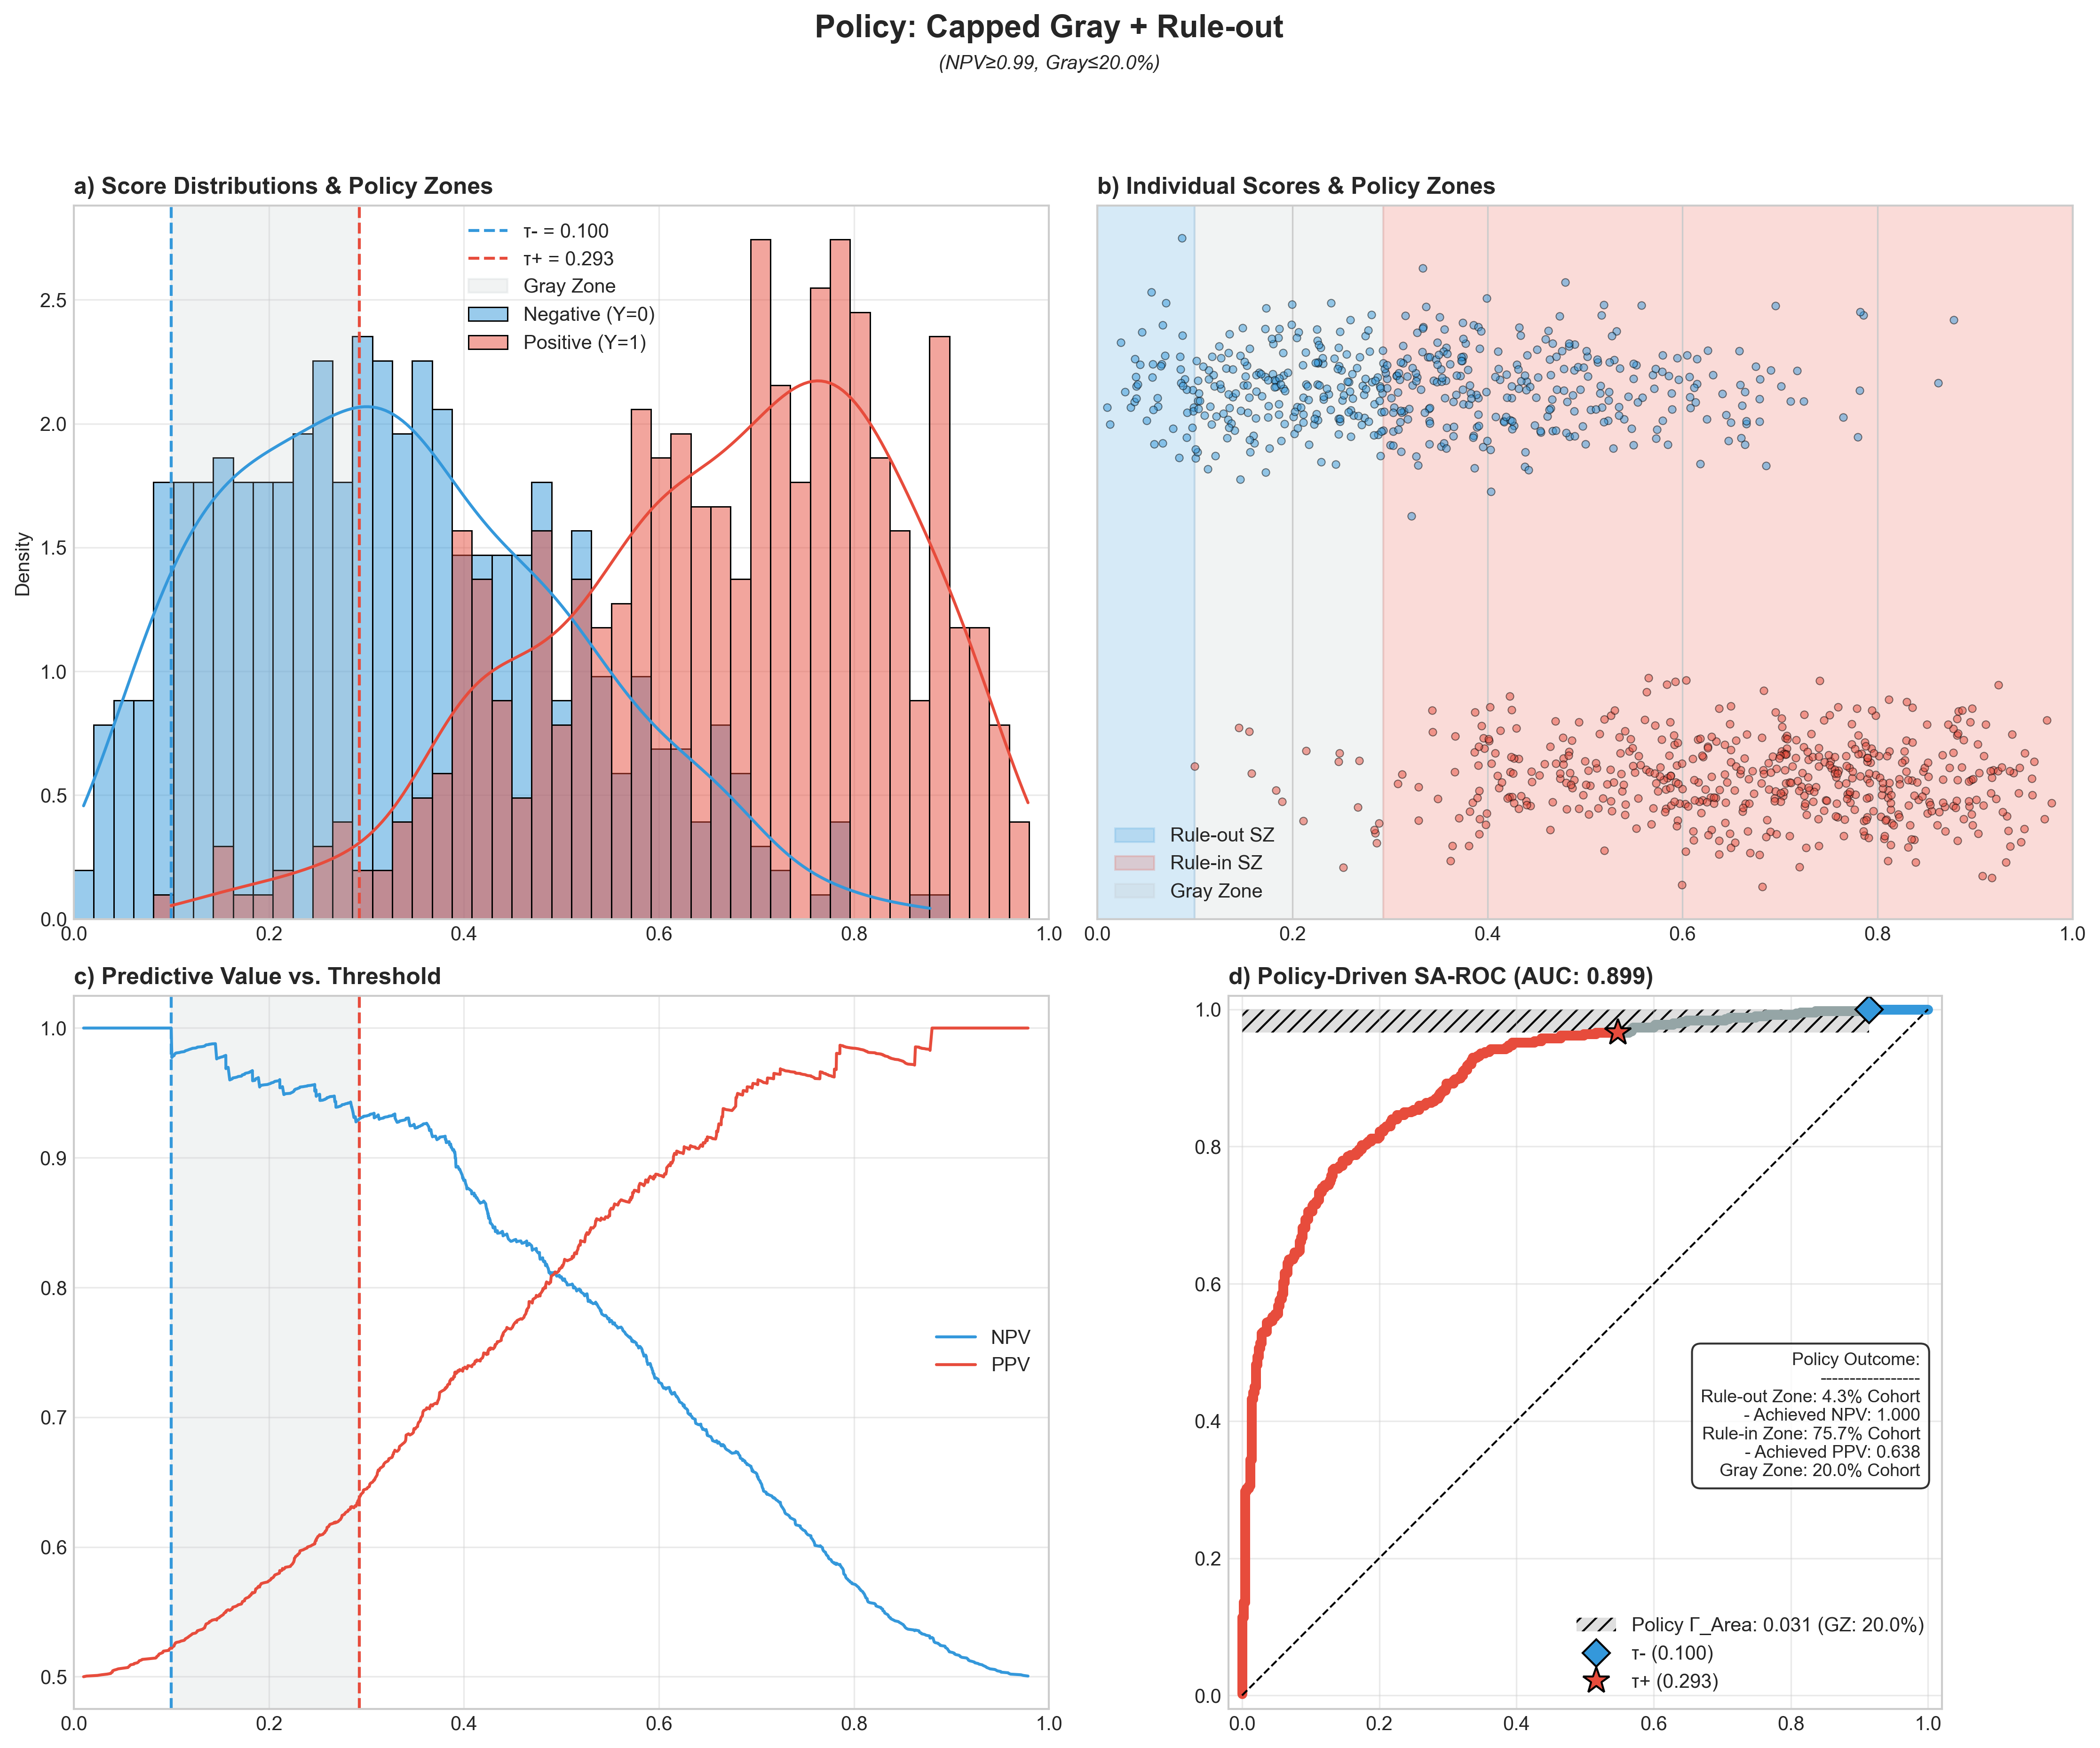


[4] Utility-Maximizing Policy
   Optimal policy:
   → τ_minus=0.145, τ_plus=0.681, Max Utility=35925.0
     Breakdown: {'tp': 264, 'tn': 82, 'fp': 14, 'fn': 1, 'n_gray': 639}
-> Plot saved to figs\policy_utility_opt_overview.png


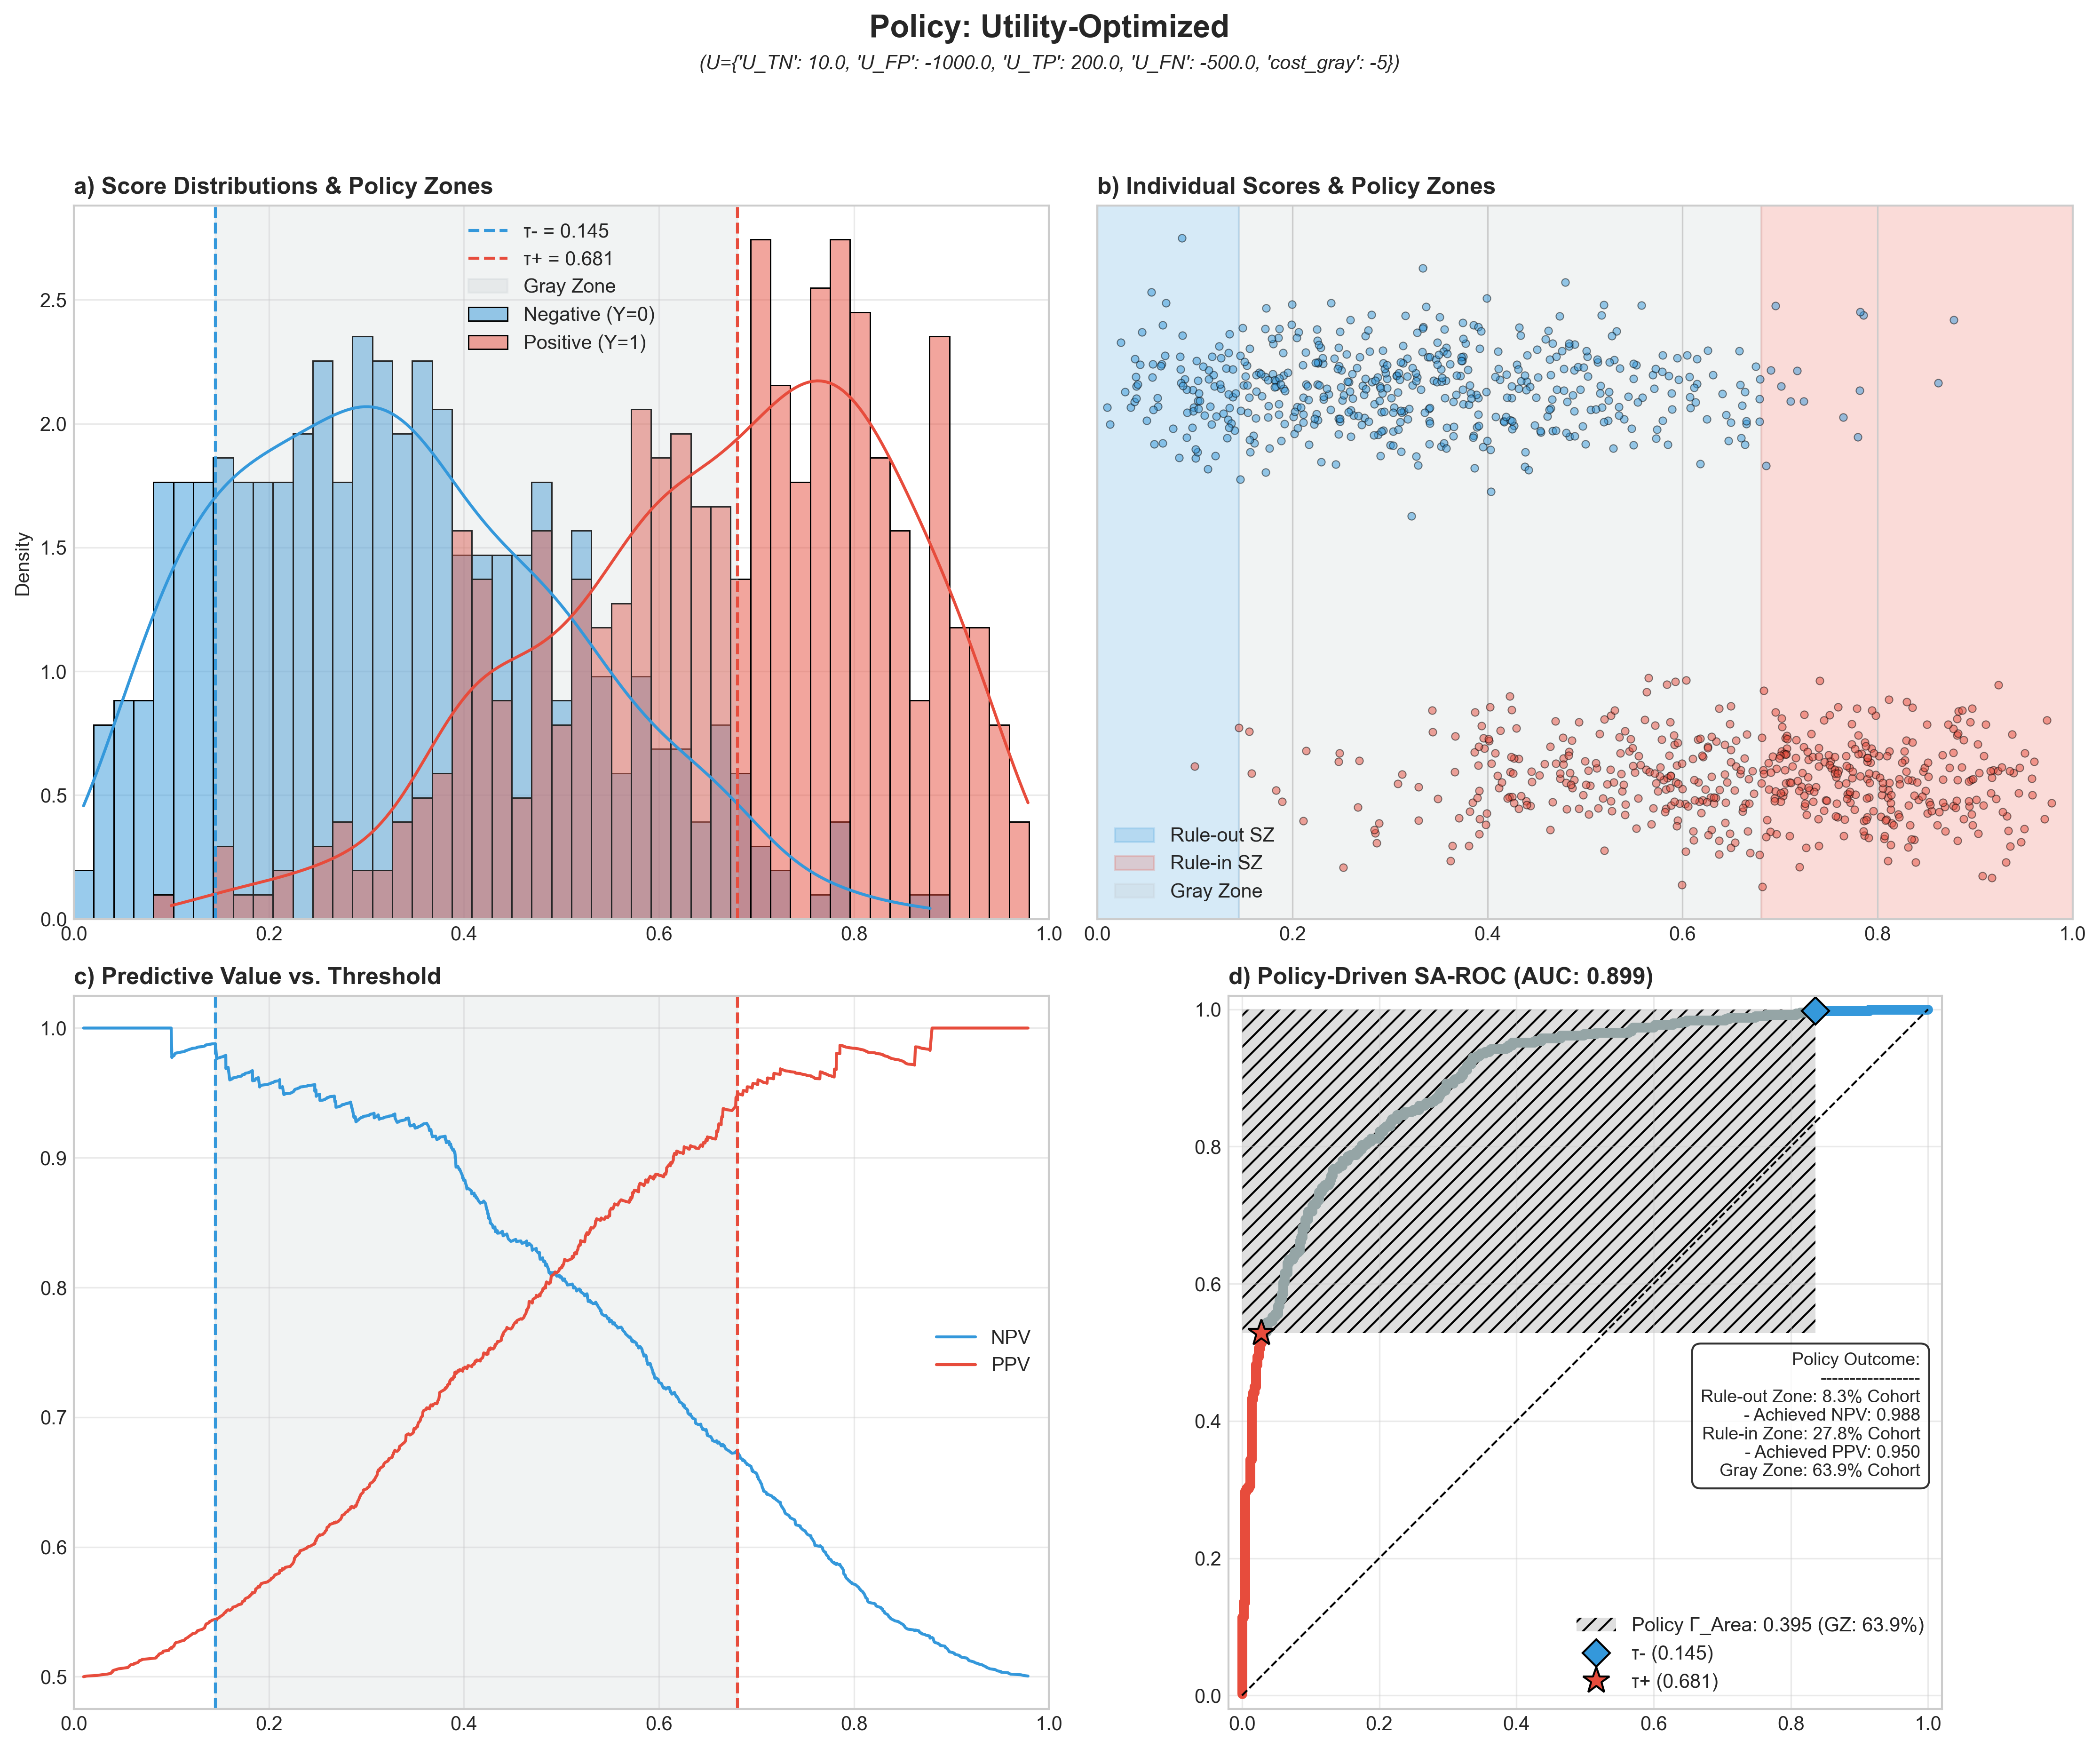

-> Plot saved to figs\policy_utility_heatmap_breakdown.png


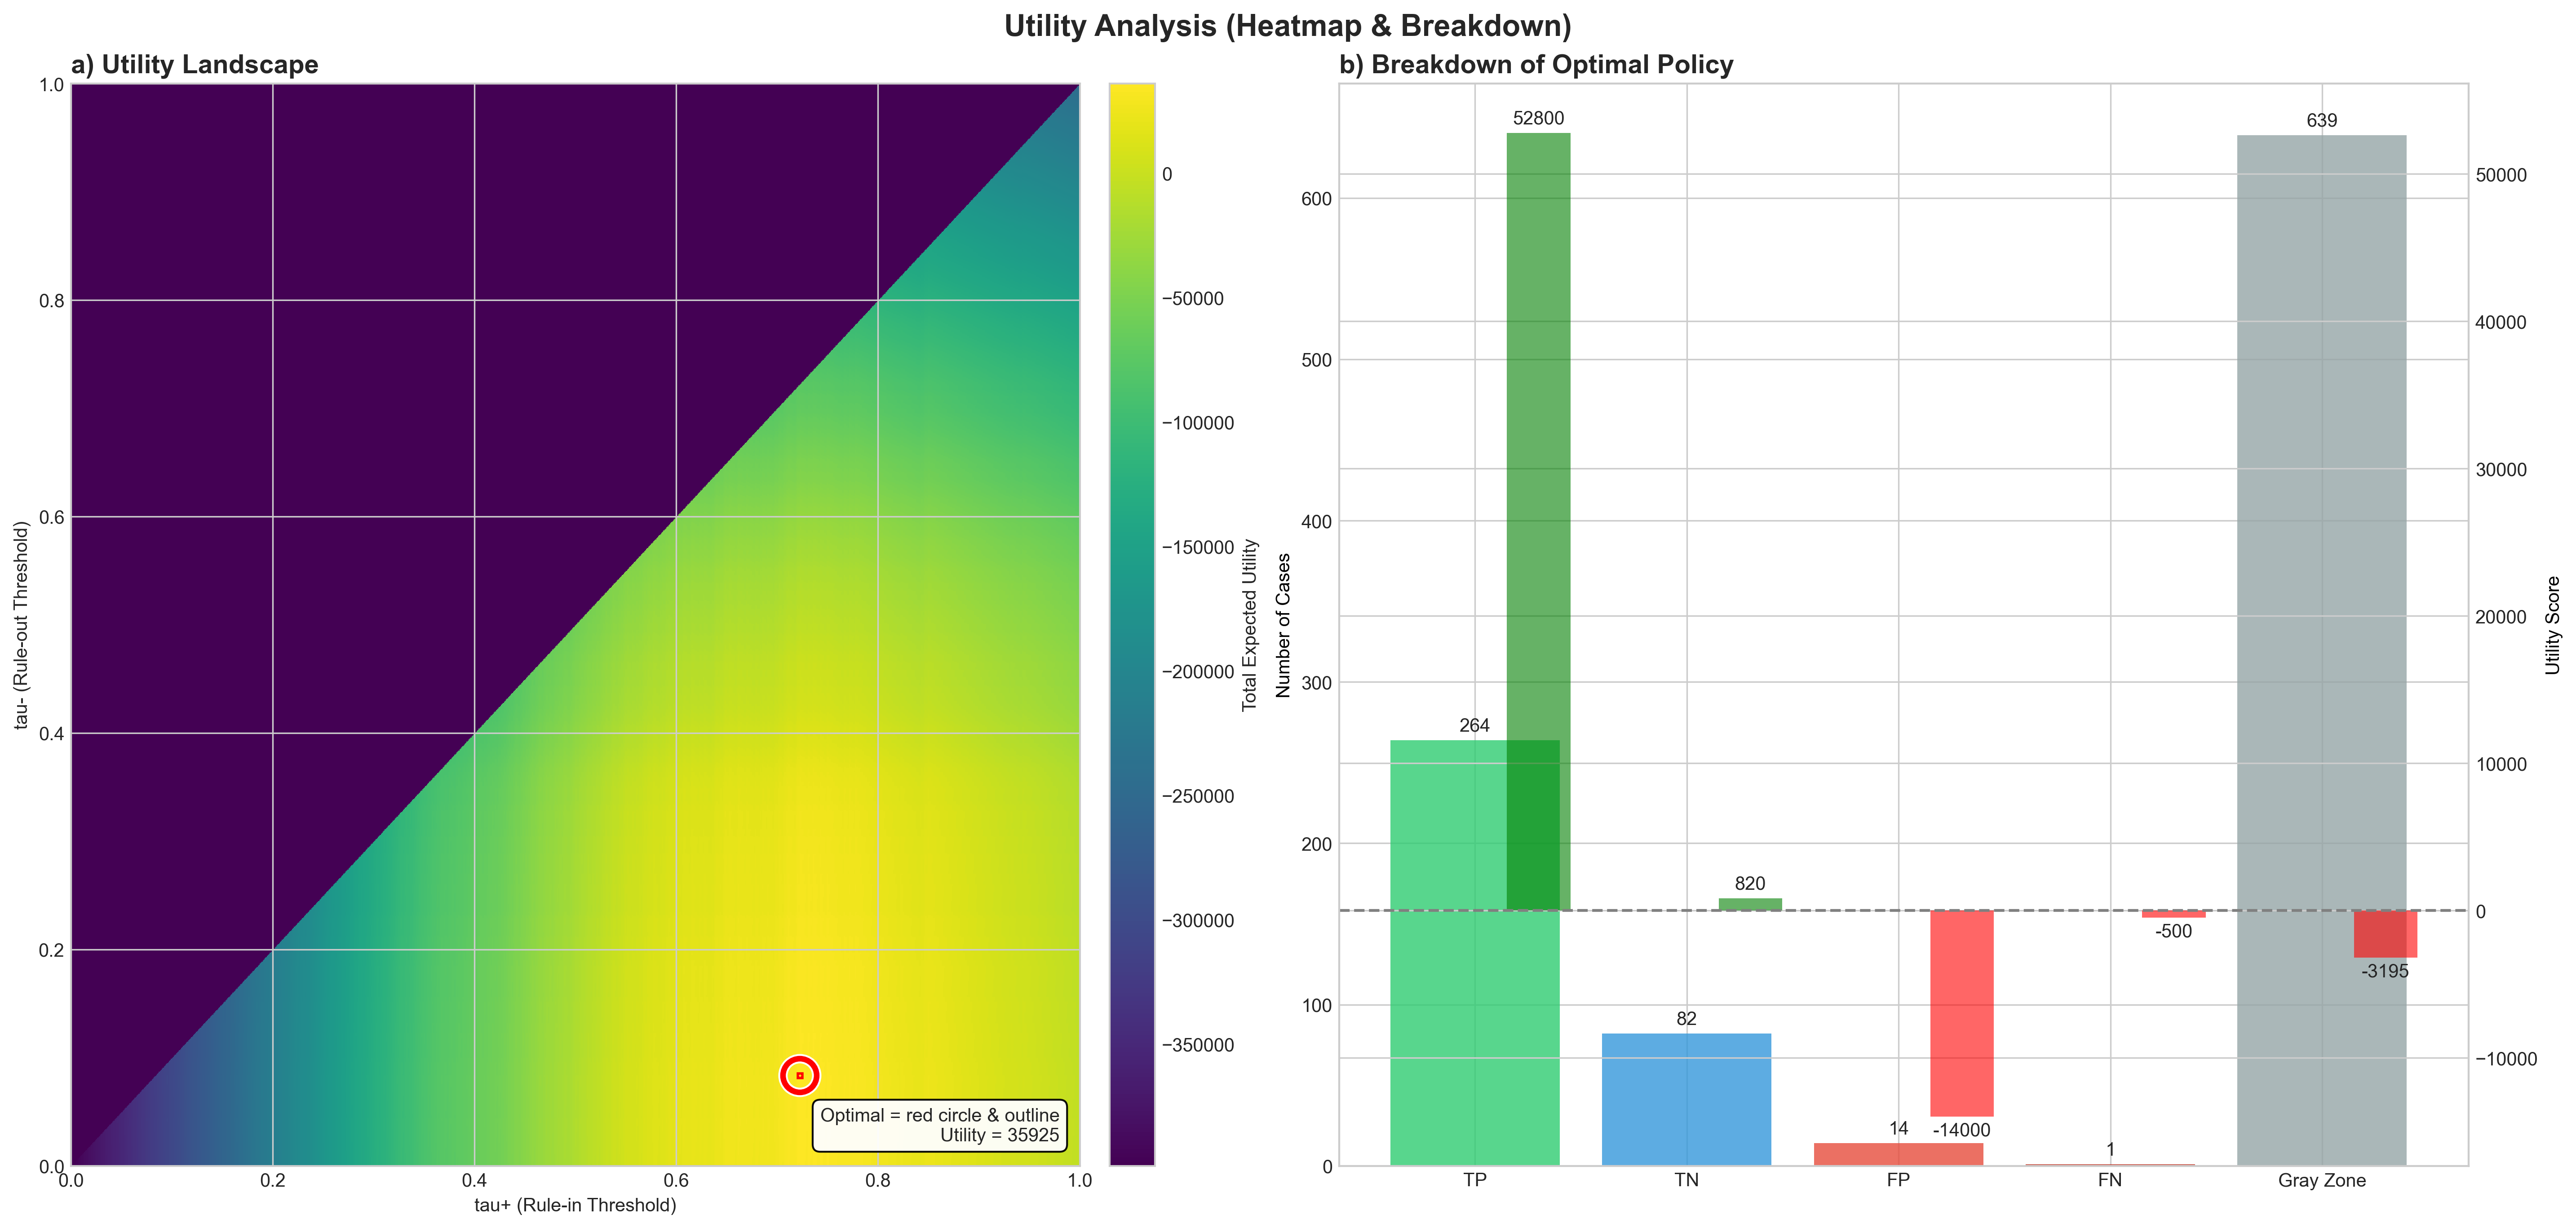

In [3]:
# Run four policy routines and render their figures.
# Assumes the data/bootstrap cell has already created `an`, `scores`, `labels`.

import os
from IPython.display import Image, display

# Validate prerequisites
try:
    an  # SA_ROC_Analyzer instance
    scores, labels  # numpy arrays
except NameError as e:
    raise RuntimeError("Prerequisite objects not found. Run the data/bootstrap cell first.") from e

# Output directory
FIG_DIR = "figs"
os.makedirs(FIG_DIR, exist_ok=True)

# ================================================================
# 1) Dual-Safety Policy (NPV ≥ α-, PPV ≥ α+)
# ================================================================
print("\n[1] Dual-Safety Policy")
alpha_minus = 0.99
alpha_plus = 0.85

rec, reason = an.recommend_policy_dual_safety(alpha_minus=alpha_minus, alpha_plus=alpha_plus)
print(f"   status: {reason}")
if rec:
    tau_minus, tau_plus = rec["tau_minus"], rec["tau_plus"]
    print(f"   → τ_minus={tau_minus:.3f}, τ_plus={tau_plus:.3f}")

    path = os.path.join(FIG_DIR, "policy_dual_safety_overview.png")
    _ = an.plot_policy_overview(
        rec,
        title="Policy: Dual Safety",
        subtitle=f"NPV≥{alpha_minus}, PPV≥{alpha_plus}",
        save_path=path
    )
    display(Image(path))
else:
    print("   No feasible (τ_minus, τ_plus) for the requested α's; skipping plots.")

# ================================================================
# 2) Capped Gray (Rule-in): Fix τ+ (PPV≥α+), grow gray ≤ cap by choosing τ-
# ================================================================
print("\n[2] Capped Gray (Rule-in)")
max_gray_pct = 40.0  # ≤ 40% of cohort allowed in gray zone
alpha_plus = 0.90

rec, reason = an.recommend_policy_capped_gray_rule_in(max_gray_pct=max_gray_pct, alpha_plus=alpha_plus)
print(f"   status: {reason}")
if rec:
    tau_minus, tau_plus = rec["tau_minus"], rec["tau_plus"]
    print(f"   → τ_minus={tau_minus:.3f}, τ_plus={tau_plus:.3f}")

    path = os.path.join(FIG_DIR, "policy_capped_gray_rulein_overview.png")
    _ = an.plot_policy_overview(
        rec,
        title="Policy: Capped Gray + Rule-in",
        subtitle=f"PPV≥{alpha_plus}, Gray≤{max_gray_pct}%",
        save_path=path
    )
    display(Image(path))
else:
    print("   No feasible policy under the specified cap and α+; skipping plot.")

# ================================================================
# 3) Capped Gray (Rule-out): Fix τ- (NPV≥α-), grow gray ≤ cap by choosing τ+
# ================================================================
print("\n[3] Capped Gray (Rule-out)")
max_gray_pct = 20.0  # ≤ 20% of cohort allowed in gray zone
alpha_minus = 0.99

rec, reason = an.recommend_policy_capped_gray_rule_out(max_gray_pct=max_gray_pct, alpha_minus=alpha_minus)
print(f"   status: {reason}")
if rec:
    tau_minus, tau_plus = rec["tau_minus"], rec["tau_plus"]
    print(f"   → τ_minus={tau_minus:.3f}, τ_plus={tau_plus:.3f}")

    path = os.path.join(FIG_DIR, "policy_capped_gray_ruleout_overview.png")
    _ = an.plot_policy_overview(
        rec,
        title="Policy: Capped Gray + Rule-out",
        subtitle=f"NPV≥{alpha_minus}, Gray≤{max_gray_pct}%",
        save_path=path
    )
    display(Image(path))
else:
    print("   No feasible policy under the specified cap and α-; skipping plot.")

# ================================================================
# 4) Utility-Maximizing Policy
# ================================================================
print("\n[4] Utility-Maximizing Policy")
utility = {
    "U_TN": +10.0,
    "U_FP": -1000.0,
    "U_TP": +200.0,
    "U_FN": -500.0, 
    "cost_gray": -5,
}

best, U, thr = an.recommend_policy_max_utility(utility)
print("   Optimal policy:")
print(f"   → τ_minus={best['tau_minus']:.3f}, τ_plus={best['tau_plus']:.3f}, Max Utility={best['max_utility']:.1f}")
print(f"     Breakdown: {best['breakdown']}")

# (a) Overview of optimal policy
path = os.path.join(FIG_DIR, "policy_utility_opt_overview.png")
_ = an.plot_policy_overview(
    {"tau_minus": best["tau_minus"], "tau_plus": best["tau_plus"]},
    title="Policy: Utility-Optimized",
    subtitle=f"U={utility}",
    save_path=path
)
display(Image(path))

# (b) Heatmap + breakdown visualization
path = os.path.join(FIG_DIR, "policy_utility_heatmap_breakdown.png")
_ = an.plot_utility_heatmap_and_breakdown(
    U, thr, best, utility,
    title="Utility Analysis (Heatmap & Breakdown)",
    save_path=path
)
display(Image(path))